# INM430 - Tiny DS Project Report


***

 Student Name:  Kimon Iliopoulos 

 Project Title: Worldwide life expectancy and it’s factors from 2000 to 2015


***




# 1. Data preprocessing

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import missingno as msno 
import plotly
import plotly.graph_objs as go
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import probplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.regression.linear_model as sm
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import plotly.express as px

## 1.1 Loading and merging the datasets

#### Merge sanitation dataset with life expectancy dataset

In [2]:
dfExp = pd.read_csv('Life Expectancy Data.csv')
dfSan = pd.read_csv('Mortality Sanitation Dataset.csv')
dfSan = dfSan[['Data Source','Unnamed: 60']]
dfSan = dfSan.drop(dfSan.index[0:4])
dfSan = dfSan.rename(columns={'Data Source': 'Country', 'Unnamed: 60': 'Sanitation Mortality/100000(2016)'})

In [3]:
newdf = pd.merge(dfExp, dfSan, on='Country', how='right')

In [4]:
newSan = pd.DataFrame(zip(dfSan.Country))
newSan = newSan.drop_duplicates(keep='first')

In [5]:
newExp = pd.DataFrame(zip(dfExp.Country))
newExp = newExp.drop_duplicates(keep='first')

In [6]:
dfExpSan = newSan.merge(newExp, how='left', indicator=True) 
dfExpSan['_merge'] = dfExpSan['_merge'].map({'left_only': False, 'both': True})
dfExpSan = dfExpSan.rename(columns={"_merge": "Common Countries"})

#### Rename some country names in order to be linked correctly

In [7]:
newSan = newSan.replace({'Congo, Dem. Rep.':'Democratic Republic of the Congo', 'Congo, Rep.':'Congo', 
                'Egypt, Arab Rep.':'Egypt', 'Micronesia, Fed. Sts.':'Micronesia (Federated States of)',
                'Gambia, The':'Gambia', 'Kyrgyz Republic':'Kyrgyzstan', 'St. Kitts and Nevis':'Saint Kitts and Nevis',
                'Korea, Rep.':'Republic of Korea', 'Korea, Dem. People’s Rep.':"Democratic People's Republic of Korea", 
                'Slovak Republic':'Slovakia', 'United States':'United States of America', 
                'St. Vincent and the Grenadines':'Saint Vincent and the Grenadines', 
                'Venezuela, RB':'Venezuela (Bolivarian Republic of)', 'Yemen, Rep.':'Yemen', 'Bahamas, The':'Bahamas'})


In [8]:
newExp = newExp.replace({'Samoa':'American Samoa', 'Bolivia (Plurinational State of)':'Bolivia',
                     'Czechia':'Czech Republic', 'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                     'Iran (Islamic Republic of)':'Iran, Islamic Rep.'})   

In [9]:
dfExpSan = newSan.merge(newExp, how='left', indicator=True) 
dfExpSan['_merge'] = dfExpSan['_merge'].map({'left_only': False, 'both': True})
dfExpSan = dfExpSan.rename(columns={"_merge": "Common Countries"})
dfExpSan = dfExpSan[dfExpSan['Common Countries'] == True]
dfExpSan = dfExpSan.rename(columns={0: "Country"})
dfSan = dfSan.merge(dfExpSan, how='left', on = 'Country') 
dfSan = dfSan[dfSan['Common Countries'] == True]
dfExp = dfExp.merge(dfSan, how='left', on = 'Country') 
dfExp = dfExp[dfExp['Common Countries'] == True]

#### Merge life expectancy and sanitation dataset with a region, subregion and country codes dataset

In [10]:
dfCountryCodes = pd.read_csv('all.csv')
dfCountryCodes = dfCountryCodes[['name', 'alpha-3', 'region', 'sub-region']]
dfCountryCodes = dfCountryCodes.rename(columns={'name': "Country"})
dfExp = dfExp.merge(dfCountryCodes, how='left', on = 'Country') 
dfExp = dfExp[dfExp.groupby('Country').Country.transform(len) > 1]
dfExp.rename(columns={'region' : 'Region', 'sub-region' : 'Sub-region', 'alpha-3' : 'Country code'}, inplace = True)
del(dfExp['Common Countries'])

In [11]:
dfExp = dfExp[dfExp.groupby('Country').Country.transform(len) > 1]

In [12]:
dfExp.rename(columns={'region' : 'Region', 'sub-region' : 'Sub-region', 'alpha-3' : 'Country code'}, inplace = True)

## 1.2 Initial Investigation of our data

In [13]:
dfExp.describe()

Year  Life expectancy   Adult Mortality  infant deaths  \
count  2496.000000       2496.000000      2496.000000    2496.000000   
mean   2007.500000         69.310056       162.610978      31.618189   
std       4.610696          9.634853       125.478491     126.363593   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2003.750000         63.000000        71.000000       0.000000   
50%    2007.500000         72.200000       138.000000       3.000000   
75%    2011.250000         75.900000       227.000000      21.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2329.000000             2496.000000  1998.000000    2496.000000   
mean      4.541408              865.038975    80.979980    2380.237179   
std       4.046048             2131.423942    24.794349   11081.701629   
min       0.010000                0.000000     2.000000       0.000000   
25%       0.760000               21.881195    77.000000       0.000000   
50%       3.810000              110.470666    92.000000      17.000000   
75%       7.560000              564.528184    96.000000     372.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

              BMI   under-five deaths   ...  Total expenditure  Diphtheria   \
count  2464.000000         2496.000000  ...        2312.000000  2477.000000   
mean     38.171916           43.998798  ...           5.850601    82.204279   
std      19.859945          171.813663  ...           2.404885    23.850289   
min       1.400000            0.000000  ...           0.370000     2.000000   
25%      19.100000            0.000000  ...           4.200000    78.000000   
50%      43.750000            3.000000  ...           5.720000    93.000000   
75%      56.100000           26.250000  ...           7.530000    97.000000   
max      77.600000         2500.000000  ...          14.390000    99.000000   

          HIV/AIDS            GDP    Population   thinness  1-19 years  \
count  2496.000000    2453.000000  2.252000e+03            2464.000000   
mean      1.687260    7564.013964  1.294174e+07               4.887338   
std       4.631042   14360.951399  6.145171e+07               4.485929   
min       0.100000       1.681350  3.400000e+01               0.100000   
25%       0.100000     464.229758  2.227102e+05               1.600000   
50%       0.100000    1763.815497  1.445401e+06               3.400000   
75%       0.800000    6256.559260  7.496690e+06               7.100000   
max      43.500000  119172.741800  1.293859e+09              27.700000   

        thinness 5-9 years  Income composition of resources    Schooling  \
count          2464.000000                      2480.000000  2480.000000   
mean              4.926664                         0.629236    12.041290   
std               4.576473                         0.216247     3.467742   
min               0.100000                         0.000000     0.000000   
25%               1.600000                         0.487000    10.100000   
50%               3.400000                         0.683000    12.400000   
75%               7.200000                         0.787000    14.500000   
max              28.600000                         0.948000    20.700000   

       Sanitation Mortality/100000(2016)  
count                        2496.000000  
mean                           12.824359  
std                            21.346748  
min                             0.100000  
25%                             0.200000  
50%                             1.150000  
75%                            18.375000  
max                           101.000000  

[8 rows x 21 columns]

In [14]:
dfExp.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

          GDP  Population   thinness  1-19 years   thinness 5-9 years  \
0  584.259210  33736494.0                   17.2                 17.3   
1  612.696514    327582.0                   17.5                 17.5   
2  631.744976  31731688.0                   17.7                 17.7   
3  669.959000   3696958.0                   17.9                 18.0   
4   63.537231   2978599.0                   18.2                 18.2   

   Income composition of resources  Schooling  \
0                            0.479       10.1   
1                            0.476       10.0   
2                            0.470        9.9   
3                            0.463        9.8   
4                            0.454        9.5   

   Sanitation Mortality/100000(2016)  Country code  Region     Sub-region  
0                               13.9           AFG    Asia  Southern Asia  
1                               13.9           AFG    Asia  Southern Asia  
2                               13.9           AFG    Asia  Southern Asia  
3                               13.9           AFG    Asia  Southern Asia  
4                               13.9           AFG    Asia  Southern Asia  

[5 rows x 26 columns]

In [15]:
dfExp.tail()

Country  Year      Status  Life expectancy   Adult Mortality  \
2498  Zimbabwe  2004  Developing              44.3            723.0   
2499  Zimbabwe  2003  Developing              44.5            715.0   
2500  Zimbabwe  2002  Developing              44.8             73.0   
2501  Zimbabwe  2001  Developing              45.3            686.0   
2502  Zimbabwe  2000  Developing              46.0            665.0   

      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
2498             27     4.36                     0.0         68.0        31   
2499             26     4.06                     0.0          7.0       998   
2500             25     4.43                     0.0         73.0       304   
2501             25     1.72                     0.0         76.0       529   
2502             24     1.68                     0.0         79.0      1483   

      ...         GDP  Population   thinness  1-19 years   thinness 5-9 years  \
2498  ...  454.366654  12777511.0                    9.4                  9.4   
2499  ...  453.351155  12633897.0                    9.8                  9.9   
2500  ...   57.348340    125525.0                    1.2                  1.3   
2501  ...  548.587312  12366165.0                    1.6                  1.7   
2502  ...  547.358879  12222251.0                   11.0                 11.2   

      Income composition of resources  Schooling  \
2498                            0.407        9.2   
2499                            0.418        9.5   
2500                            0.427       10.0   
2501                            0.427        9.8   
2502                            0.434        9.8   

      Sanitation Mortality/100000(2016)  Country code  Region  \
2498                               24.6           ZWE  Africa   
2499                               24.6           ZWE  Africa   
2500                               24.6           ZWE  Africa   
2501                               24.6           ZWE  Africa   
2502                               24.6           ZWE  Africa   

              Sub-region  
2498  Sub-Saharan Africa  
2499  Sub-Saharan Africa  
2500  Sub-Saharan Africa  
2501  Sub-Saharan Africa  
2502  Sub-Saharan Africa  

[5 rows x 26 columns]

#### Splitting the dataset to categorical and numerical for later use

In [16]:
categoricalFeats = dfExp.select_dtypes(include=[np.object])
categoricalFeats.columns

Index(['Country', 'Status', 'Country code', 'Region', 'Sub-region'], dtype='object')

In [17]:
numericalFeats = dfExp.select_dtypes(include=[np.number])
numericalFeats.columns

Index(['Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Sanitation Mortality/100000(2016)'],
      dtype='object')

## 1.3 Handling missing values

#### Visualizing the missing values of our dataset

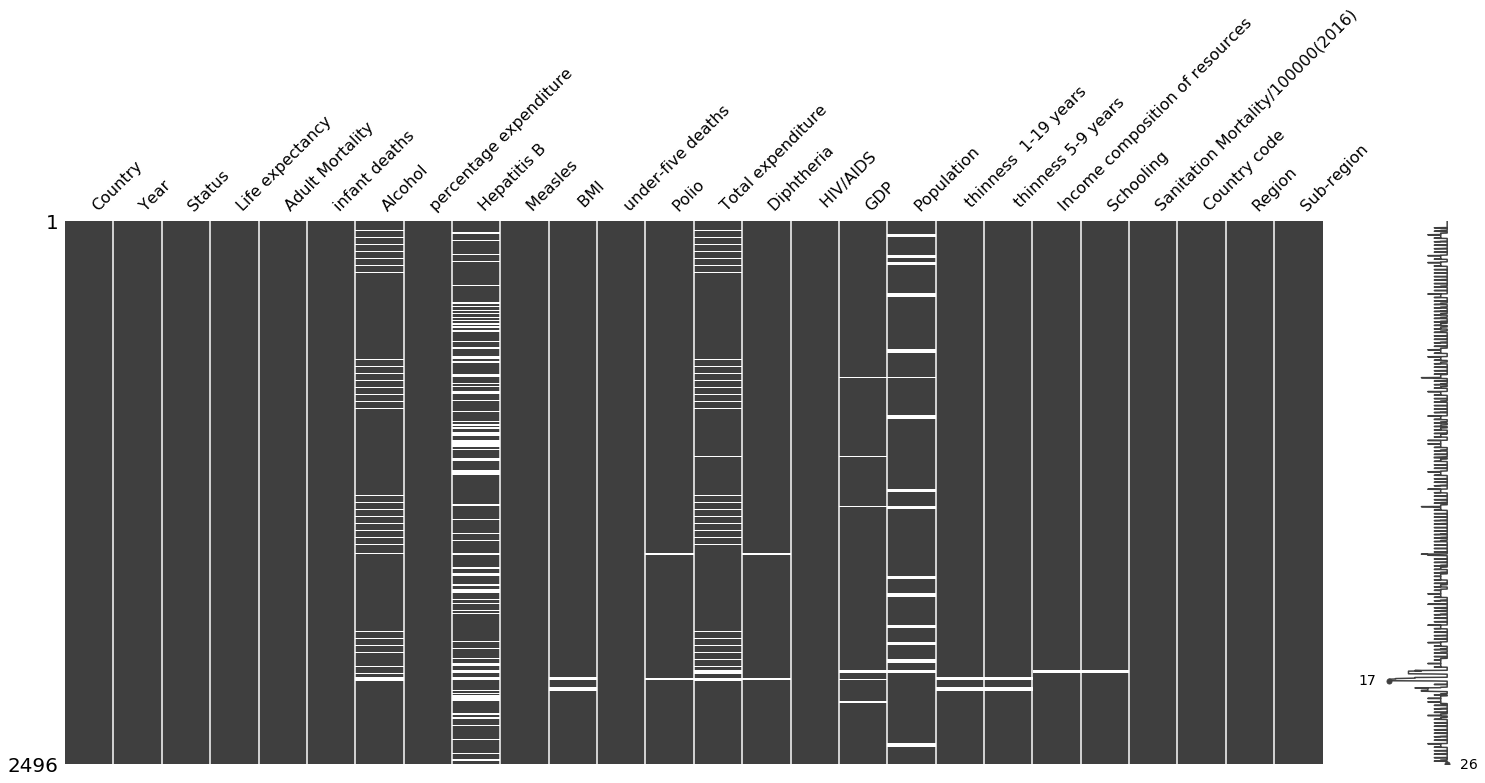

In [18]:
msno.matrix(dfExp)

##### The white lines in this matrix represent the missing values of our dataset.

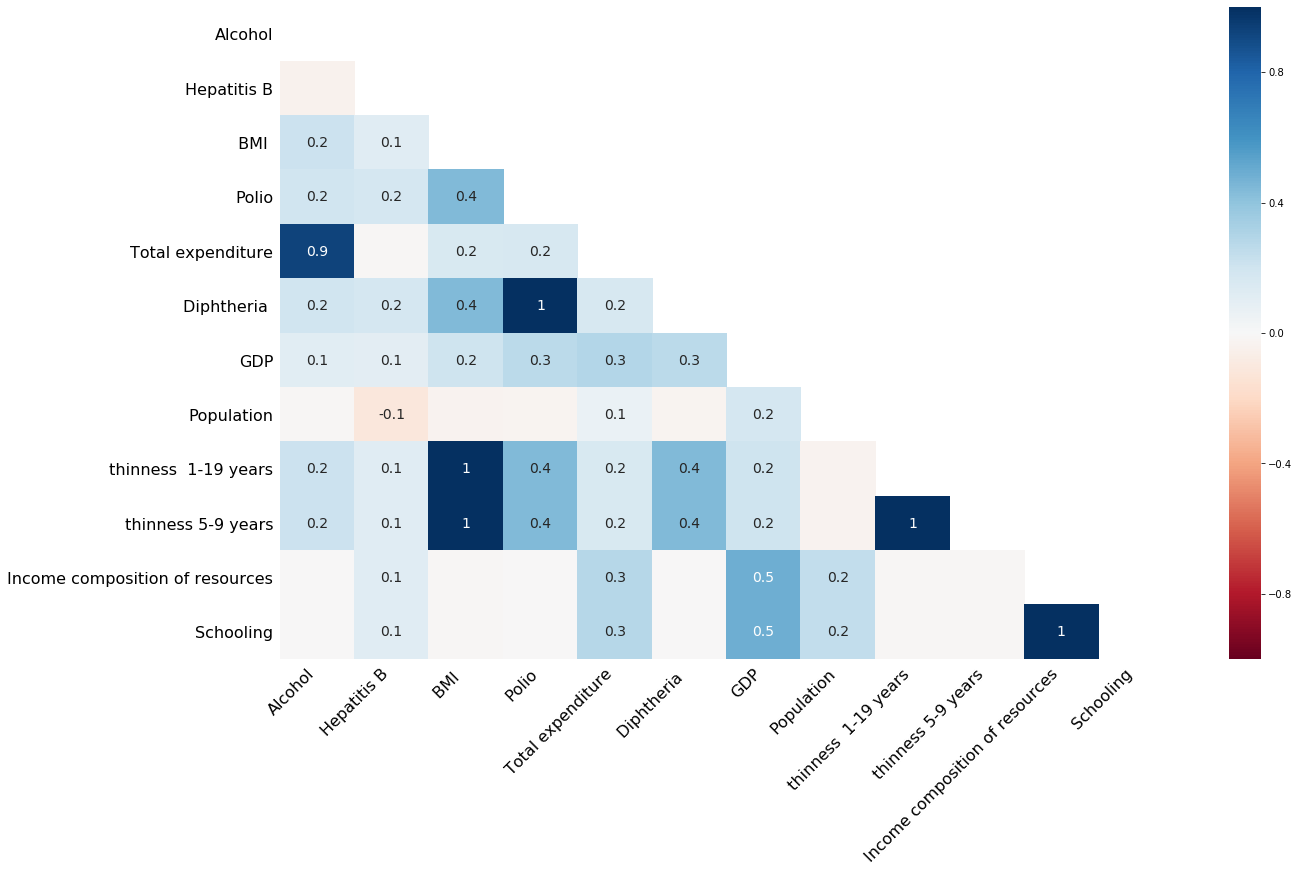

In [19]:
msno.heatmap(dfExp)

##### The heatmap shows how the presence or absence of a value of a feature affects the presence or absence of another feature. From what we see, 'thinness 1-19 years' and 'thinness 5-9 years' and 'BMI' have a very high correlation. Than means that if a value in one of these columns is missing, we can be sure that the same row is going to be missed in the other columns as well. Furthermore, high correlation is noticed with 'Total expenditure' and 'Alcohol', 'Diphtheria' and 'Polio' and lastly 'Schooling' and 'Income composition of resources'.

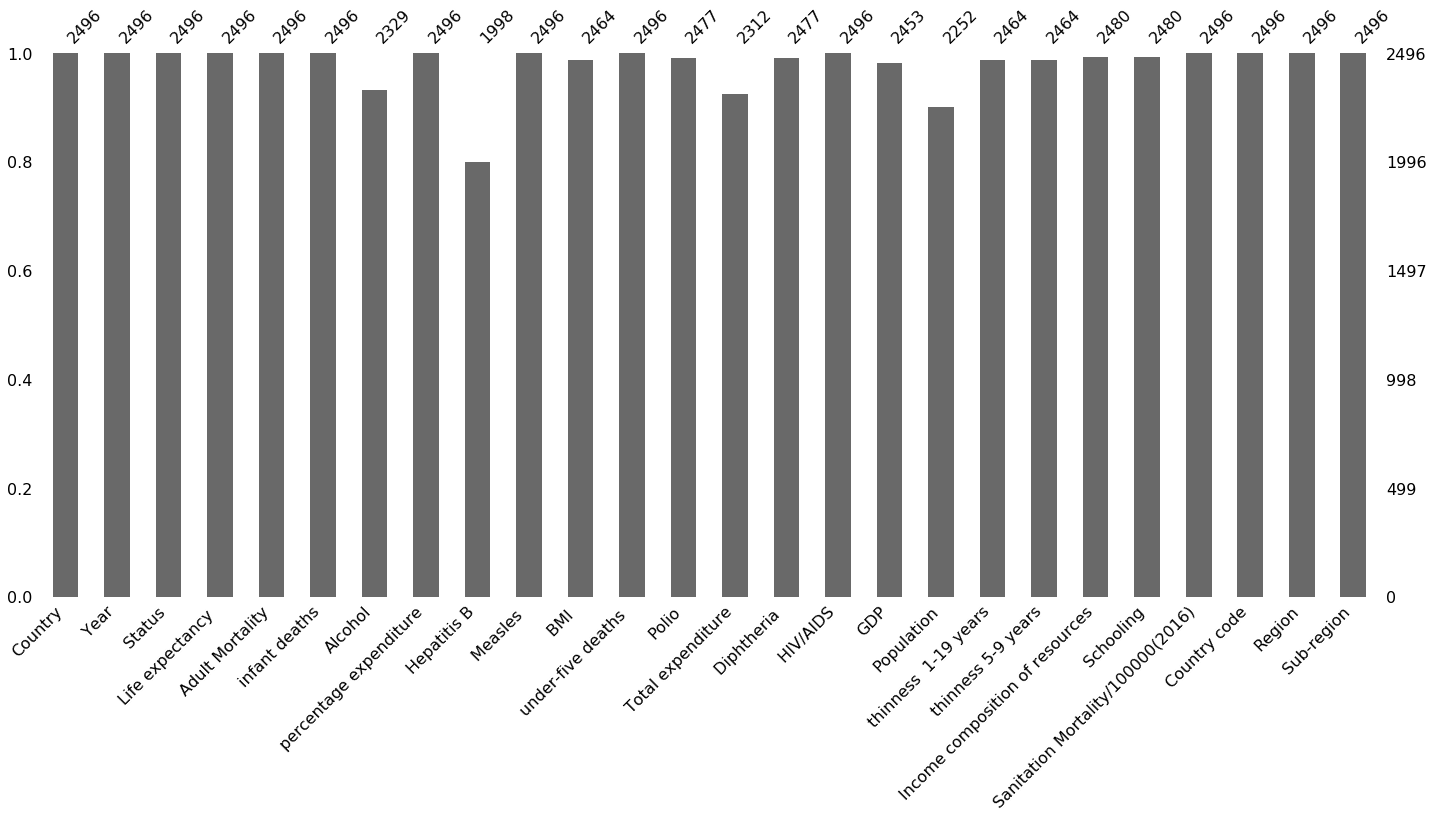

In [20]:
msno.bar(dfExp)

##### This barplot shows the total non null ammount of values (total rows of the dataset) that every feature has.

#### Which feature type has missing values?

In [21]:
numericalFeatsMissingValues = numericalFeats.isnull().sum().sort_values(ascending=False)
numericalFeatsMissingValuesPerc = ((numericalFeats.isnull().sum()/numericalFeats.isnull().count())*100).sort_values(ascending=False)
numericalFeatsMissingData = pd.concat([numericalFeatsMissingValues, numericalFeatsMissingValuesPerc], axis=1,join='outer', keys=['Total Missing Numerical Values', '% of Total Observations'])
numericalFeatsMissingData.index.name =' Numerical Feature'
numericalFeatsMissingData

Total Missing Numerical Values  \
 Numerical Feature                                                  
Hepatitis B                                                   498   
Population                                                    244   
Total expenditure                                             184   
Alcohol                                                       167   
GDP                                                            43   
 thinness 5-9 years                                            32   
 thinness  1-19 years                                          32   
 BMI                                                           32   
Polio                                                          19   
Diphtheria                                                     19   
Income composition of resources                                16   
Schooling                                                      16   
Life expectancy                                                 0   
Adult Mortality                                                 0   
infant deaths                                                   0   
Sanitation Mortality/100000(2016)                               0   
percentage expenditure                                          0   
Measles                                                         0   
under-five deaths                                               0   
 HIV/AIDS                                                       0   
Year                                                            0   

                                   % of Total Observations  
 Numerical Feature                                          
Hepatitis B                                      19.951923  
Population                                        9.775641  
Total expenditure                                 7.371795  
Alcohol                                           6.690705  
GDP                                               1.722756  
 thinness 5-9 years                               1.282051  
 thinness  1-19 years                             1.282051  
 BMI                                              1.282051  
Polio                                             0.761218  
Diphtheria                                        0.761218  
Income composition of resources                   0.641026  
Schooling                                         0.641026  
Life expectancy                                   0.000000  
Adult Mortality                                   0.000000  
infant deaths                                     0.000000  
Sanitation Mortality/100000(2016)                 0.000000  
percentage expenditure                            0.000000  
Measles                                           0.000000  
under-five deaths                                 0.000000  
 HIV/AIDS                                         0.000000  
Year                                              0.000000

In [22]:
categoricalFeatsMissingValues = categoricalFeats.isnull().sum().sort_values(ascending=False)
categoricalFeatsMissingValuesPerc = (categoricalFeats.isnull().sum()/categoricalFeats.isnull().count()).sort_values(ascending=False)
categoricalFeatsMissingData = pd.concat([categoricalFeatsMissingValues, categoricalFeatsMissingValuesPerc], axis=1,join='outer', keys=['Total Missing Categorical Values', '% of Total Observations'])
categoricalFeatsMissingData.index.name =' Categorical Feature'
categoricalFeatsMissingData

Total Missing Categorical Values  \
 Categorical Feature                                     
Sub-region                                           0   
Region                                               0   
Country code                                         0   
Status                                               0   
Country                                              0   

                      % of Total Observations  
 Categorical Feature                           
Sub-region                                0.0  
Region                                    0.0  
Country code                              0.0  
Status                                    0.0  
Country                                   0.0

##### The tables above show the number of missing values per feature, and their percentage from all it's length. Only the numerical features have missing values.

In [23]:
dfExpImputed = numericalFeats.copy()
dfExpImputed = pd.concat([categoricalFeats, dfExpImputed], axis=1)

#### Fill null values with the mean of the column for a given country

In [24]:
for column in dfExpImputed.columns[5:]:
    dfExpImputed[column] = dfExpImputed.groupby('Country').transform(lambda x: x.fillna(x.mean()))[column]
print('Missing values after fillna based on country')
dfExpImputedMissingValues = dfExpImputed.isnull().sum().sort_values(ascending=False)
dfExpImputedMissingValuesPerc = (dfExpImputed.isnull().sum()/dfExpImputed.isnull().count()).sort_values(ascending=False)
dfExpImputedMissingData = pd.concat([dfExpImputedMissingValues, dfExpImputedMissingValuesPerc], axis=1,join='outer', keys=['Total Missing Values', '% of Total Observations'])
dfExpImputedMissingData

Missing values after fillna based on country


Total Missing Values  \
Population                                          240   
Hepatitis B                                         128   
 thinness 5-9 years                                  32   
 thinness  1-19 years                                32   
 BMI                                                 32   
Alcohol                                              16   
Income composition of resources                      16   
Schooling                                            16   
Total expenditure                                    16   
Year                                                  0   
Life expectancy                                       0   
Sanitation Mortality/100000(2016)                     0   
Sub-region                                            0   
Adult Mortality                                       0   
Country code                                          0   
Status                                                0   
Region                                                0   
Measles                                               0   
infant deaths                                         0   
percentage expenditure                                0   
under-five deaths                                     0   
Polio                                                 0   
Diphtheria                                            0   
 HIV/AIDS                                             0   
GDP                                                   0   
Country                                               0   

                                   % of Total Observations  
Population                                        0.096154  
Hepatitis B                                       0.051282  
 thinness 5-9 years                               0.012821  
 thinness  1-19 years                             0.012821  
 BMI                                              0.012821  
Alcohol                                           0.006410  
Income composition of resources                   0.006410  
Schooling                                         0.006410  
Total expenditure                                 0.006410  
Year                                              0.000000  
Life expectancy                                   0.000000  
Sanitation Mortality/100000(2016)                 0.000000  
Sub-region                                        0.000000  
Adult Mortality                                   0.000000  
Country code                                      0.000000  
Status                                            0.000000  
Region                                            0.000000  
Measles                                           0.000000  
infant deaths                                     0.000000  
percentage expenditure                            0.000000  
under-five deaths                                 0.000000  
Polio                                             0.000000  
Diphtheria                                        0.000000  
 HIV/AIDS                                         0.000000  
GDP                                               0.000000  
Country                                           0.000000

##### We did not manage to fill all the null values. Some columns are completely empty for the given country; no values to calculate the mean.

#### Remaining missing values will be imputed with the mean of a wider geographical area; the sub-region that every country belongs to.

In [25]:
for column in dfExpImputed.columns[5:]:
    dfExpImputed[column] = dfExpImputed.groupby('Sub-region').transform(lambda x: x.fillna(x.mean()))[column]
print('Missing values after fillna based on subregion')
dfExpImputedMissingValues = dfExpImputed.isnull().sum().sort_values(ascending=False)
dfExpImputedMissingValuesPerc = (dfExpImputed.isnull().sum()/dfExpImputed.isnull().count()).sort_values(ascending=False)
dfExpImputedMissingData = pd.concat([dfExpImputedMissingValues, dfExpImputedMissingValuesPerc], axis=1,join='outer', keys=['Total Missing Values', '% of Total Observations'])
dfExpImputedMissingData

Missing values after fillna based on subregion


Total Missing Values  \
Sanitation Mortality/100000(2016)                     0   
Schooling                                             0   
Status                                                0   
Country code                                          0   
Region                                                0   
Sub-region                                            0   
Year                                                  0   
Life expectancy                                       0   
Adult Mortality                                       0   
infant deaths                                         0   
Alcohol                                               0   
percentage expenditure                                0   
Hepatitis B                                           0   
Measles                                               0   
 BMI                                                  0   
under-five deaths                                     0   
Polio                                                 0   
Total expenditure                                     0   
Diphtheria                                            0   
 HIV/AIDS                                             0   
GDP                                                   0   
Population                                            0   
 thinness  1-19 years                                 0   
 thinness 5-9 years                                   0   
Income composition of resources                       0   
Country                                               0   

                                   % of Total Observations  
Sanitation Mortality/100000(2016)                      0.0  
Schooling                                              0.0  
Status                                                 0.0  
Country code                                           0.0  
Region                                                 0.0  
Sub-region                                             0.0  
Year                                                   0.0  
Life expectancy                                        0.0  
Adult Mortality                                        0.0  
infant deaths                                          0.0  
Alcohol                                                0.0  
percentage expenditure                                 0.0  
Hepatitis B                                            0.0  
Measles                                                0.0  
 BMI                                                   0.0  
under-five deaths                                      0.0  
Polio                                                  0.0  
Total expenditure                                      0.0  
Diphtheria                                             0.0  
 HIV/AIDS                                              0.0  
GDP                                                    0.0  
Population                                             0.0  
 thinness  1-19 years                                  0.0  
 thinness 5-9 years                                    0.0  
Income composition of resources                        0.0  
Country                                                0.0

#### Change the data types after concatenated the dataframes

In [26]:
dfExpImputed['Year'] = dfExpImputed['Year'].astype('int64') 
dfExpImputed['Measles '] = dfExpImputed['Measles '].astype('int64') 
dfExpImputed['under-five deaths '] = dfExpImputed['under-five deaths '].astype('int64') 
dfExpImputed['infant deaths'] = dfExpImputed['infant deaths'].astype('int64') 

#### Split the imputed dataset to numerican and categorcal for later use

In [27]:
categoricalImputedFeats = dfExpImputed.select_dtypes(include=[np.object])
categoricalImputedFeats.columns

Index(['Country', 'Status', 'Country code', 'Region', 'Sub-region'], dtype='object')

In [28]:
numericalImputedFeats = dfExpImputed.select_dtypes(include=[np.number])
numericalImputedFeats.columns

Index(['Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Sanitation Mortality/100000(2016)'],
      dtype='object')

# 1.4 Handling outliers

#### Visualizing the outliers of our dataset

#### Outliers before winsorizing 

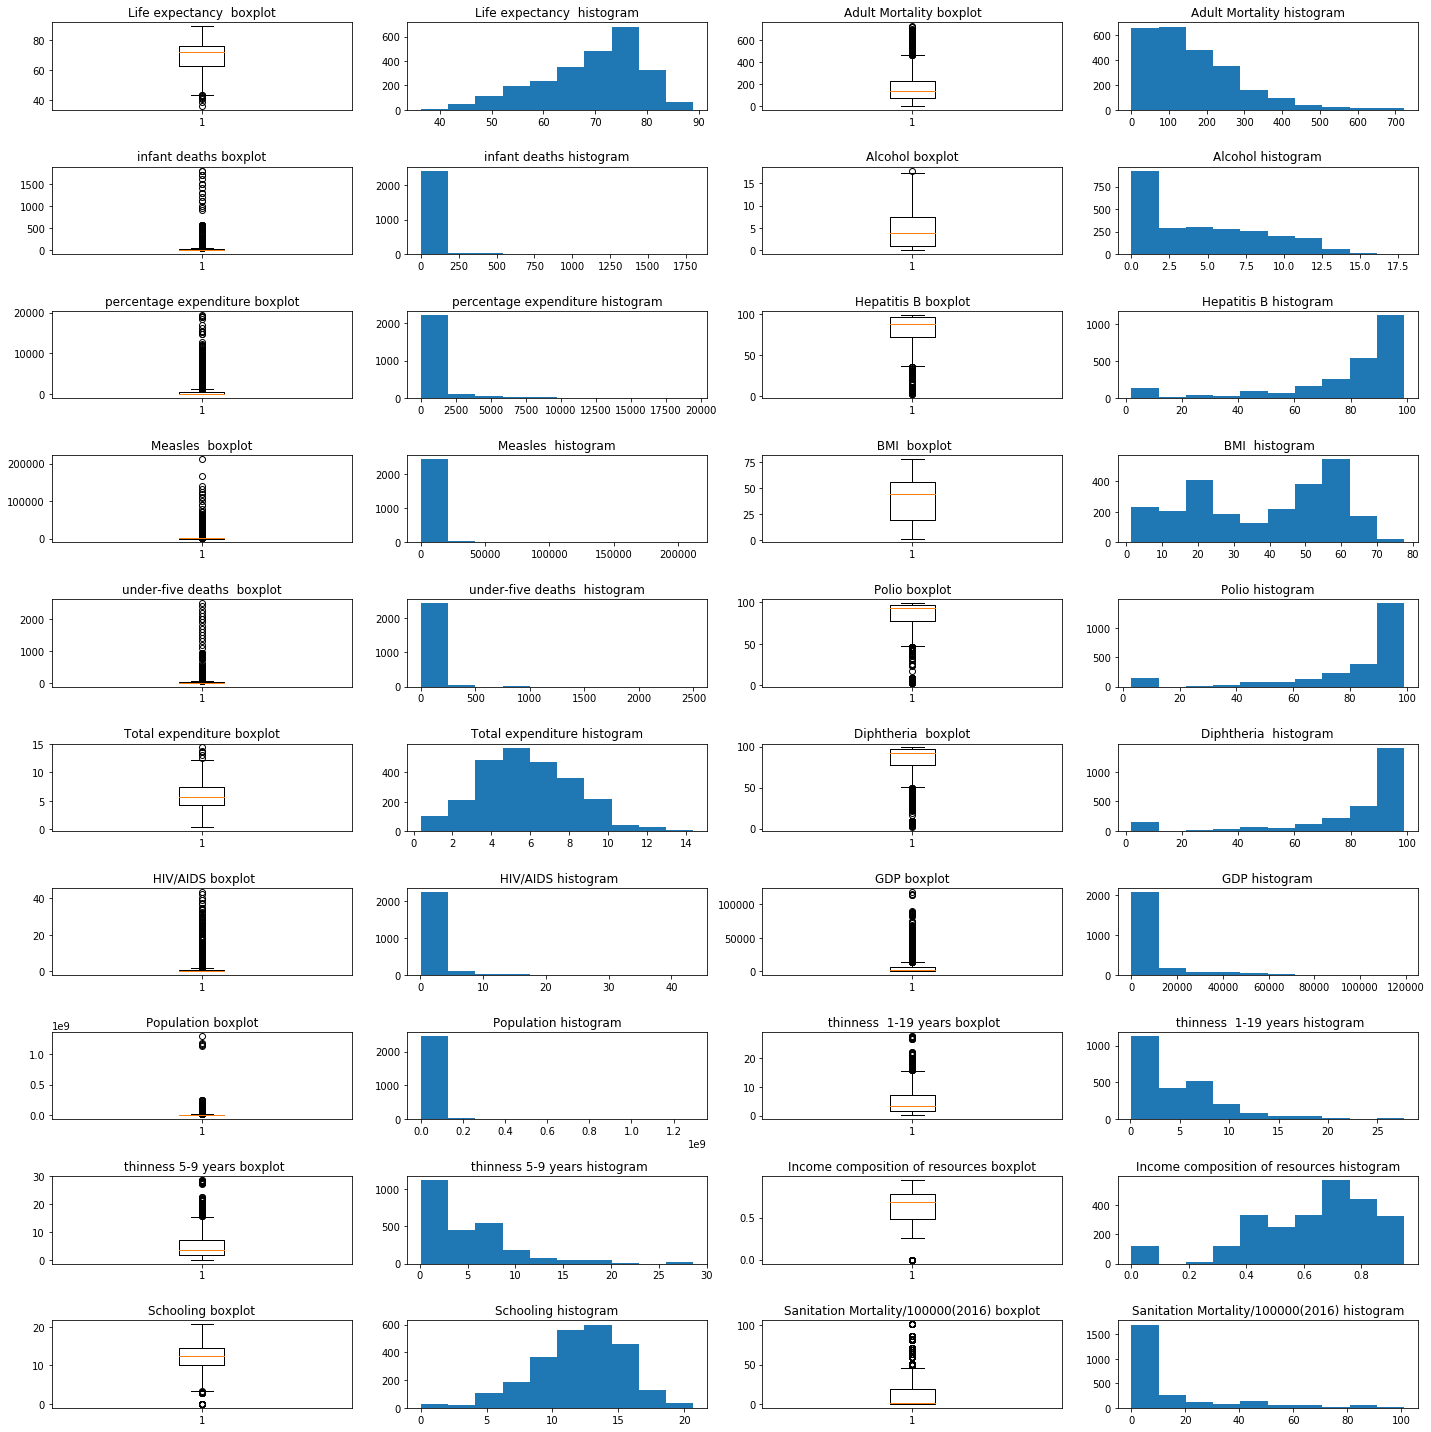

In [29]:
columns = numericalImputedFeats.drop('Year', axis = 1)
plt.figure(figsize=(20, 20))
i = 0
for feature in columns:
    i += 1
    plt.subplot(10, 4, i)
    plt.tight_layout()
    plt.boxplot(numericalImputedFeats[feature])
    plt.title('{} boxplot'.format(feature))
    i += 1
    plt.subplot(10, 4, i )
    plt.tight_layout()
    plt.hist(numericalImputedFeats[feature])
    plt.title('{} histogram'.format(feature))
plt.show()

#####  This figure shows the boxplot and histogram for every numeric feature of the dataset before winsorizing the outliers.

#### Winsorizing the outliers; they will not be deleted in order not to lose important information. Manually setted percentiles for every feature outside of which the outliers would be replaced.

In [30]:
winsorizedNumericalImputedFeats = numericalImputedFeats.copy()
winsorizedNumericalImputedFeats['Life expectancy '] = winsorize(numericalImputedFeats['Life expectancy '], (0.01, 0))

winsorizedNumericalImputedFeats['Adult Mortality'] = winsorize(numericalImputedFeats['Adult Mortality'], (0, 0.03))

winsorizedNumericalImputedFeats['infant deaths'] = winsorize(numericalImputedFeats['infant deaths'], (0, 0.12))

winsorizedNumericalImputedFeats['Alcohol'] = winsorize(numericalImputedFeats['Alcohol'], (0, 0.01))

winsorizedNumericalImputedFeats['percentage expenditure'] = winsorize(numericalImputedFeats['percentage expenditure'], (0, 0.14))

winsorizedNumericalImputedFeats['Hepatitis B'] = winsorize(numericalImputedFeats['Hepatitis B'], (0.11, 0))

winsorizedNumericalImputedFeats['Measles '] = winsorize(numericalImputedFeats['Measles '], (0, 0.19))

winsorizedNumericalImputedFeats['under-five deaths '] = winsorize(numericalImputedFeats['under-five deaths '], (0, 0.145))

winsorizedNumericalImputedFeats['Polio'] = winsorize(numericalImputedFeats['Polio'], (0.1, 0))

winsorizedNumericalImputedFeats['Total expenditure'] = winsorize(numericalImputedFeats['Total expenditure'], (0, 0.01))

winsorizedNumericalImputedFeats['Diphtheria '] = winsorize(numericalImputedFeats['Diphtheria '], (0.11, 0))

winsorizedNumericalImputedFeats[' HIV/AIDS'] = winsorize(numericalImputedFeats[' HIV/AIDS'], (0, 0.185))

winsorizedNumericalImputedFeats['GDP'] = winsorize(numericalImputedFeats['GDP'], (0, 0.155))

winsorizedNumericalImputedFeats['Population'] = winsorize(numericalImputedFeats['Population'], (0, 0.14))

winsorizedNumericalImputedFeats[' thinness  1-19 years'] = winsorize(numericalImputedFeats[' thinness  1-19 years'], (0, 0.04))

winsorizedNumericalImputedFeats[' thinness 5-9 years'] = winsorize(numericalImputedFeats[' thinness 5-9 years'], (0, 0.04))

winsorizedNumericalImputedFeats['Income composition of resources'] = winsorize(numericalImputedFeats['Income composition of resources'], (0.05, 0))

winsorizedNumericalImputedFeats['Schooling'] = winsorize(numericalImputedFeats['Schooling'], (0.02, 0.01))

winsorizedNumericalImputedFeats['Sanitation Mortality/100000(2016)'] = winsorize(numericalImputedFeats['Sanitation Mortality/100000(2016)'], (0, 0.099))


#### Outliers after winsorizing 

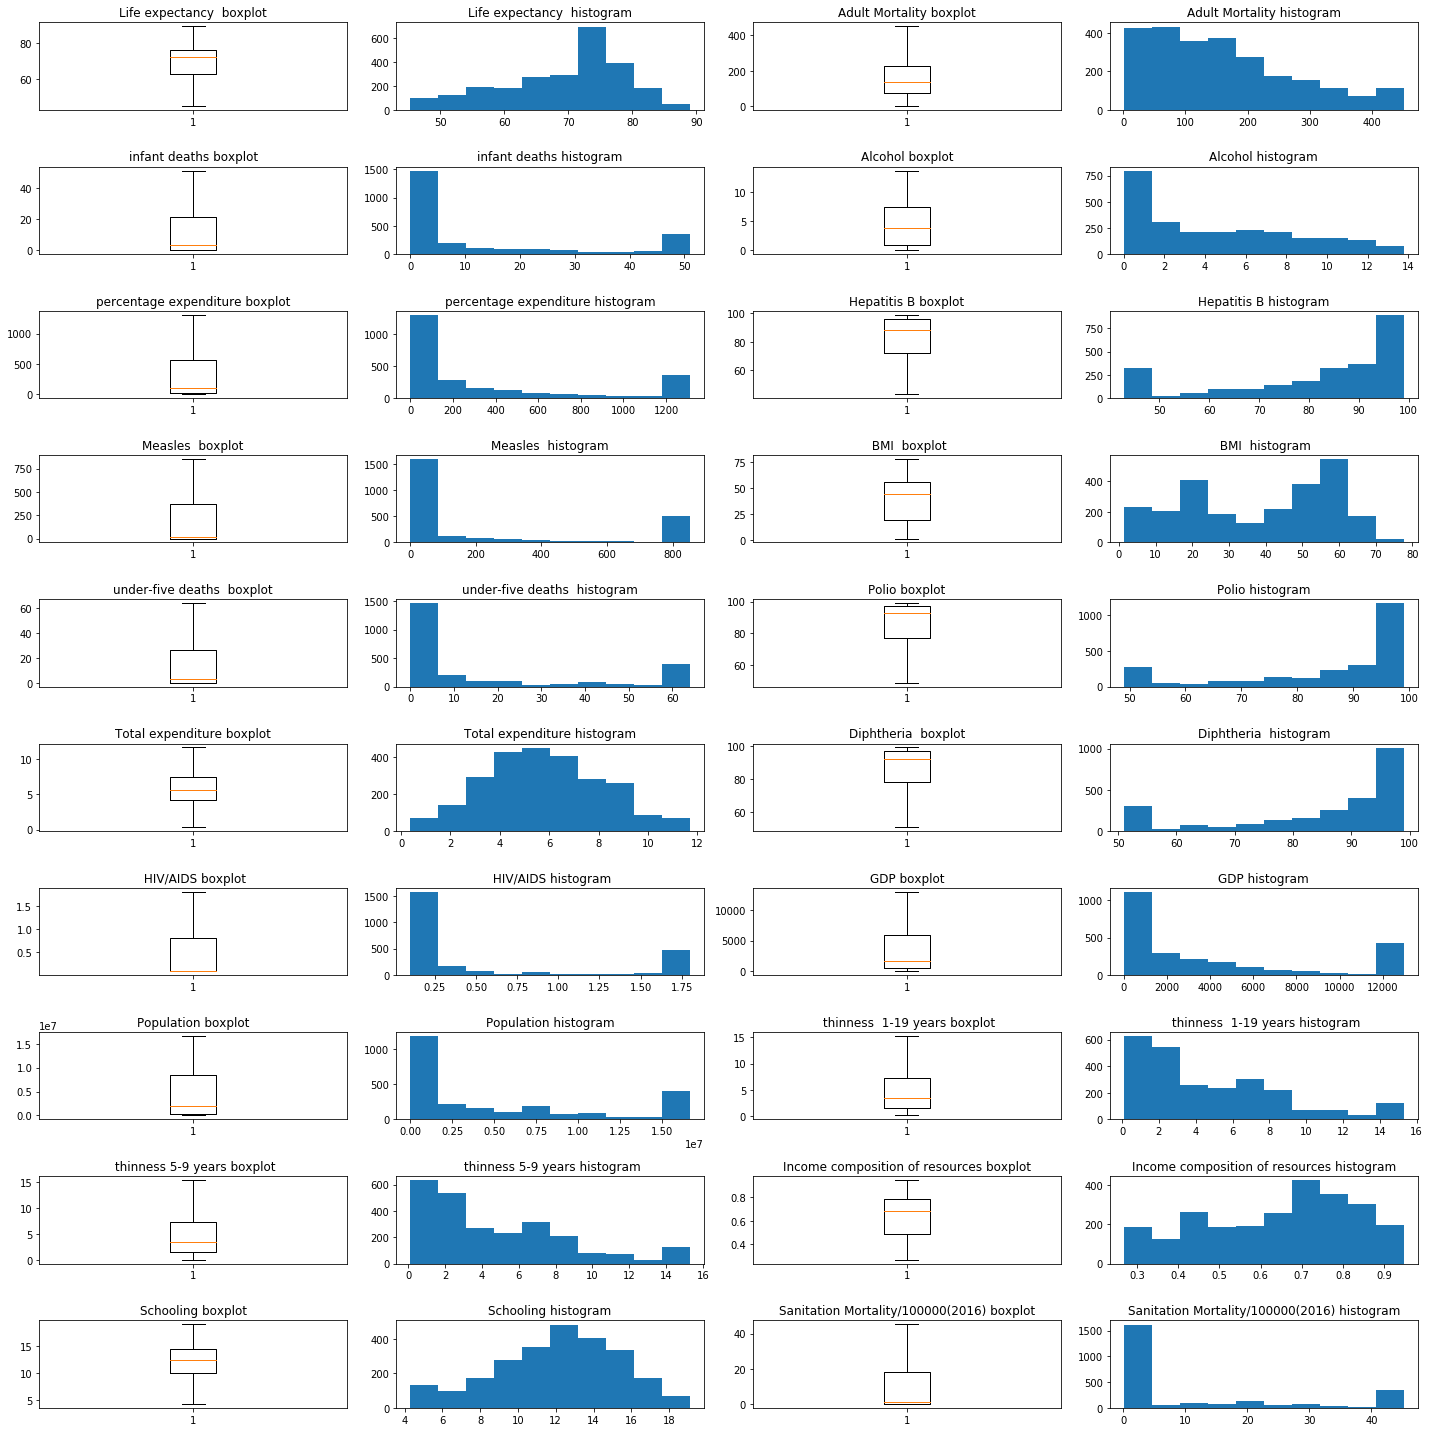

In [31]:
plt.figure(figsize=(20, 20))
i = 0
for feature in winsorizedNumericalImputedFeats.drop('Year', axis = 1):
    i += 1
    plt.subplot(10, 4, i)
    plt.tight_layout()
    plt.boxplot(winsorizedNumericalImputedFeats[feature])
    plt.title('{} boxplot'.format(feature))
    i += 1
    plt.subplot(10, 4, i )
    plt.tight_layout()
    plt.hist(winsorizedNumericalImputedFeats[feature])
    plt.title('{} histogram'.format(feature))
plt.show()

##### This figure shows the boxplot and histogram for every numeric feature of the dataset after winsorizing the outliers.

# 2. Exploratory Data Analysis (EDA)

## 2.1 Initial exploration of the data

#### Merge the categorical with the winsorized numerical features

In [32]:
winsorizedImputedFeats = pd.concat([categoricalImputedFeats, winsorizedNumericalImputedFeats], axis=1)

#### Features's relation with the target variable

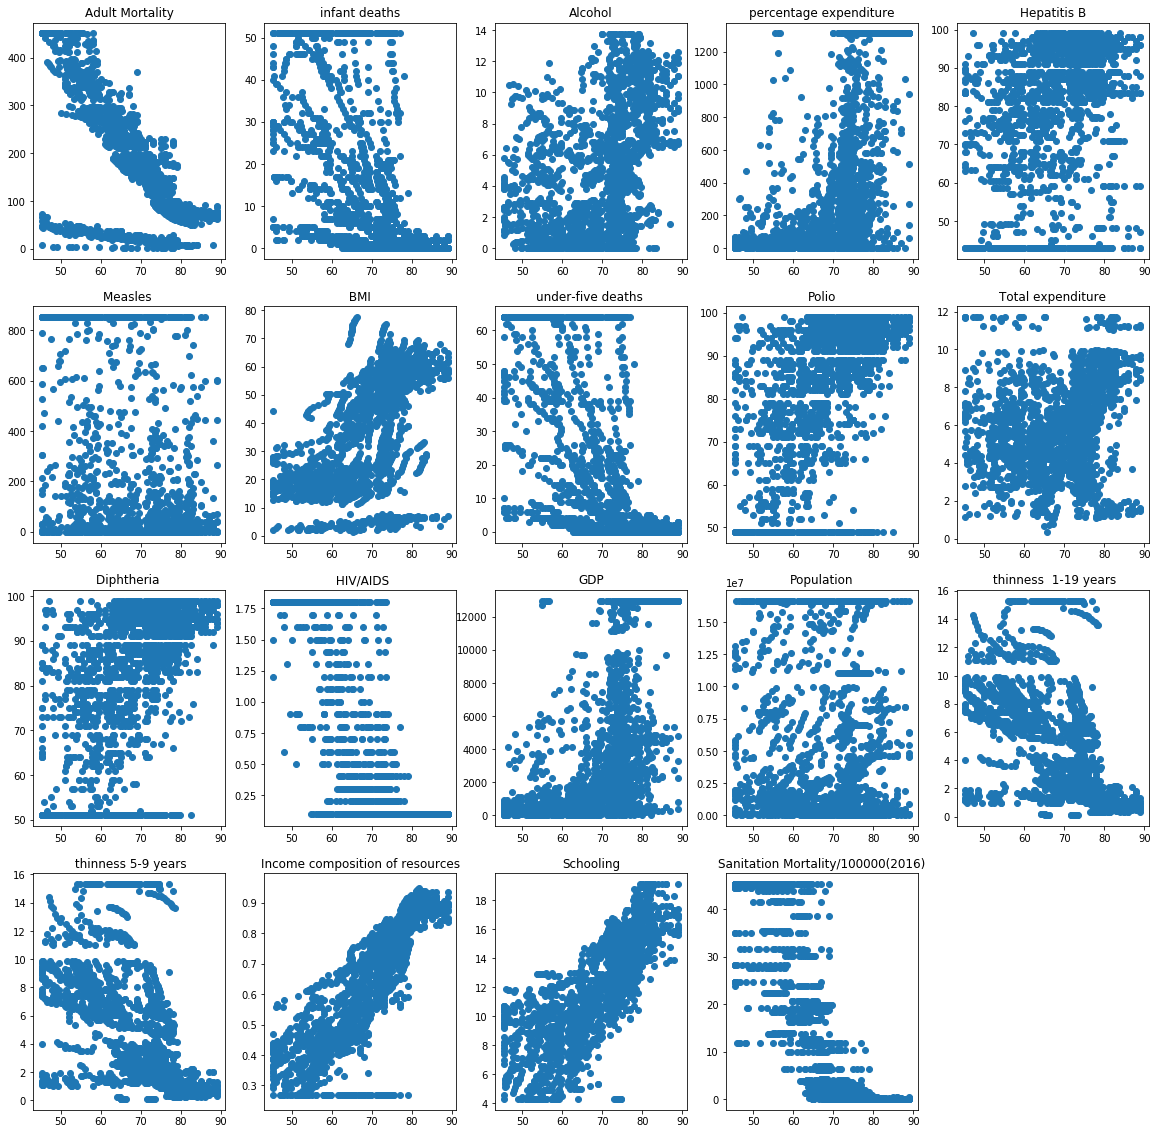

In [33]:
columns = winsorizedNumericalImputedFeats.columns.drop(['Life expectancy ', 'Year'])
plt.figure(figsize = (20, 20))
for i in range(len(columns)):
    plt.subplot(4, 5, i + 1)
    plt.scatter(winsorizedNumericalImputedFeats['Life expectancy '], winsorizedNumericalImputedFeats[columns[i]])
    plt.title(columns[i])

##### This scatter plot shows that 'Schooling', 'Income composition of resources' and 'BMI' have a strong positive correlation with Life Expectancy. On the other hand 'Adult Mortality', 'HIV/AIDS' and 'Sanitation/Mortality/100000(2016)' have a negative correlation with Life Expectancy.

#### Correlation matrix between all the numerical features

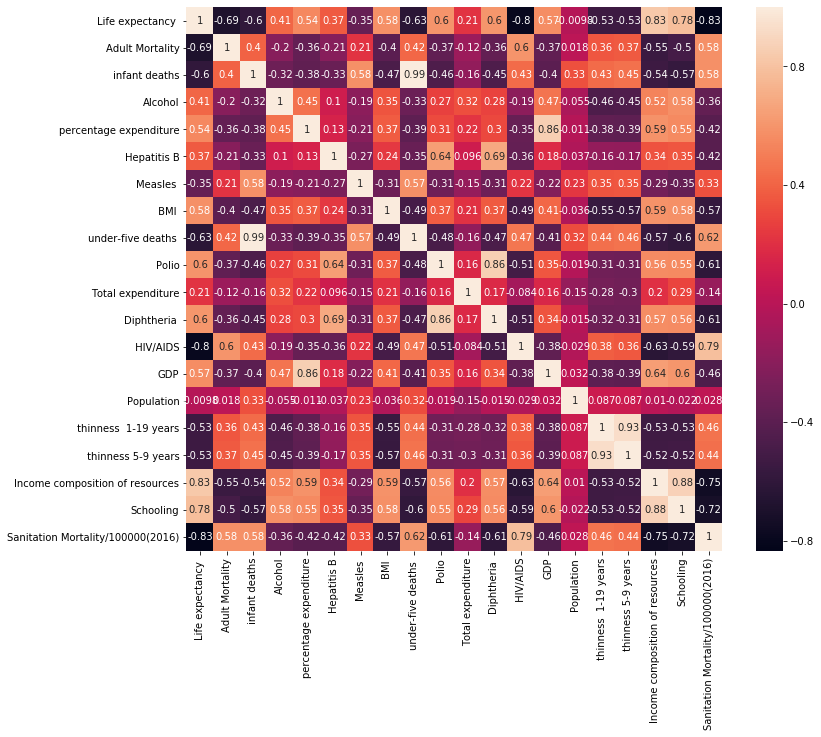

In [34]:
Corr1 = winsorizedNumericalImputedFeats.drop('Year', axis = 1).corr()
plt.figure(figsize = (12, 10))
sns.heatmap(Corr1, annot = True)

#### Features with an absolute correlation with target variable > 0.5

In [35]:
corrLifeExp = abs(Corr1["Life expectancy "])
bestFeatures = corrLifeExp[corrLifeExp>0.5]
bestFeatures = bestFeatures.drop('Life expectancy ')
bestFeatures.sort_values()

 thinness  1-19 years                0.532835
 thinness 5-9 years                  0.533007
percentage expenditure               0.543289
GDP                                  0.568068
 BMI                                 0.579977
infant deaths                        0.596335
Polio                                0.596832
Diphtheria                           0.601323
under-five deaths                    0.631817
Adult Mortality                      0.688418
Schooling                            0.781977
 HIV/AIDS                            0.795503
Sanitation Mortality/100000(2016)    0.832925
Income composition of resources      0.833566
Name: Life expectancy , dtype: float64

##### Feature selection will take place based on the correlation of every feature of the dataset with life expectancy. Given this assumption the last 5 features of the above table will be selected.

#### Further investigation of Adult Mortality, Schooling, HIV/AIDS, Income composition of resources and Sanitation Mortality.

#### Correlation matrix between the top 5 correlated features to the target variable

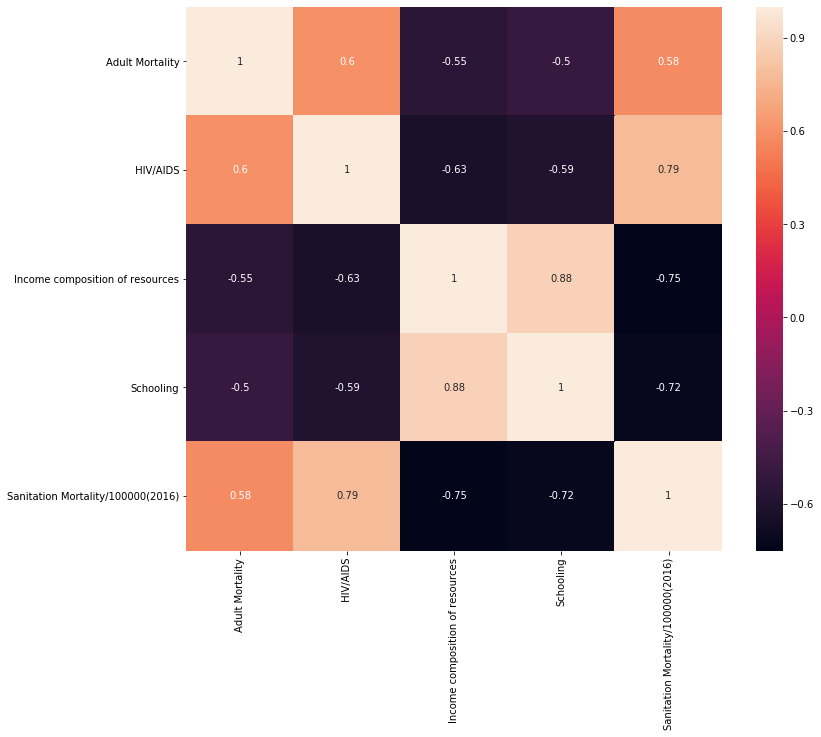

In [36]:
Corr2 = winsorizedNumericalImputedFeats[['Adult Mortality', ' HIV/AIDS', 'Income composition of resources', 'Schooling',
       'Sanitation Mortality/100000(2016)']].corr()
plt.figure(figsize = (12, 10))
sns.heatmap(Corr2, annot = True)

##### 'Adult Mortality' has a positive correlation with 'Sanitation Mortality/100000(2016)' and 'HIV/AIDS'. 
##### 'BMI' has a positive correlation with 'Schooling' and 'Income composition of resources' and a negative one with  'Sanitation Mortality/100000(2016)'.
#####  'HIV/AIDS' represents a positive correlation only with 'Adult Mortality'.
##### 'Income composition of resources' has a positive correlation with  'Schooling' and 'BMI' and a negative correlation with 'Sanitation Mortality/100000(2016)'.
#####  'Schooling' has a negative correlation with 'Sanitation Mortality/100000(2016)'.

## 2.2 Feature selection based on the Filter Method

#### Selection of the highly correlated features with the target variable

In [37]:
winsorizedImputedSelectedFeats = winsorizedImputedFeats.drop(['infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
                                                            'Measles ', ' BMI ', 'GDP', 'Population', ' thinness  1-19 years',
                                                            ' thinness 5-9 years', 'under-five deaths ', 'Polio',
                                                             'Diphtheria ', 'Total expenditure'], axis = 1)
winsorizedImputedCatSelectedFeats = winsorizedImputedSelectedFeats.select_dtypes(include=[np.object])
winsorizedImputedCNumSelectedFeats = winsorizedImputedSelectedFeats.select_dtypes(include=[np.number])

##### Feature selection is applied for the modeling part (3.) of this project.

## 2.3 Basic statistics of the dataset

Text(0.5, 1.0, 'Skewness after winsorizing the outliers')

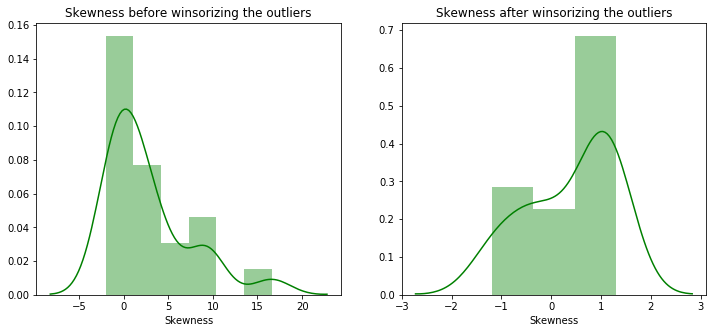

In [38]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
sns.distplot(numericalImputedFeats.skew(),color='green',axlabel ='Skewness')
plt.title('Skewness before winsorizing the outliers')
plt.subplot(1, 2, 2)
sns.distplot(winsorizedNumericalImputedFeats.skew(),color='green',axlabel ='Skewness')
plt.title('Skewness after winsorizing the outliers')

##### Skewness before winsorizing the outliers on the left, skewness after winsorizing the outliers on the right.

Text(0.5, 1.0, 'Kurtosis after winsorizing the outliers')

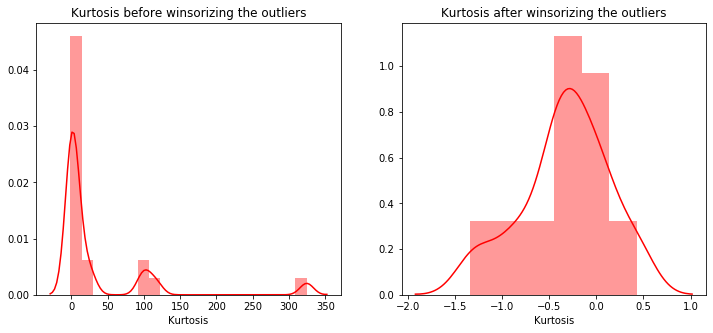

In [39]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
sns.distplot(numericalImputedFeats.kurt(),color='red',axlabel ='Kurtosis')
plt.title('Kurtosis before winsorizing the outliers')
plt.subplot(1, 2, 2)
sns.distplot(winsorizedNumericalImputedFeats.kurt(),color='red',axlabel ='Kurtosis')
plt.title('Kurtosis after winsorizing the outliers')

##### Kurtosis before winsorizing the outliers on the left, kurtosis after winsorizing the outliers on the right.

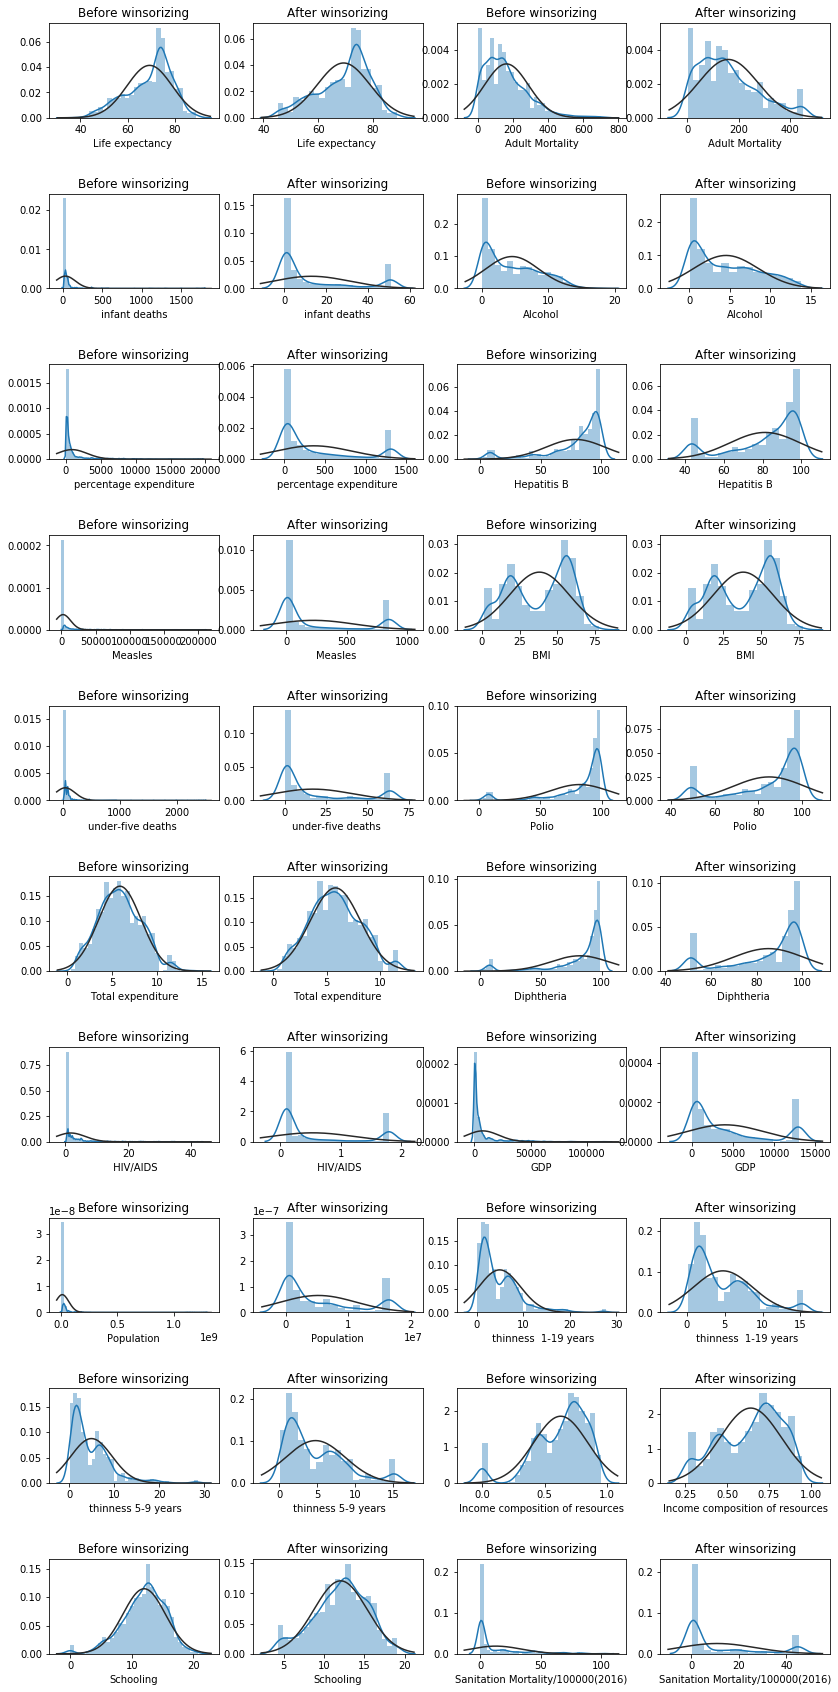

In [40]:
columns = ['Life expectancy ', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Sanitation Mortality/100000(2016)']
plt.figure(figsize = (14, 30))
counter = 0
for i in range(len(columns)):
    counter += 1
    plt.subplot(10, 4, counter)
    sns.distplot(numericalImputedFeats[columns[i]], fit=norm)
    plt.subplots_adjust(hspace = 0.8)
    plt.title('Before winsorizing')
    counter += 1
    plt.subplot(10, 4, counter)
    sns.distplot(winsorizedNumericalImputedFeats[columns[i]], fit=norm);
    plt.subplots_adjust(hspace = 0.8)
    plt.title('After winsorizing')

##### This figure shows how the distribution of every feature changed after applying winsorizing. We see that after winsorizing the outliers of our dataset, every feature became more normal than before.

## 2.4 Life expectancy exploration

#### Life expectancy values for every country

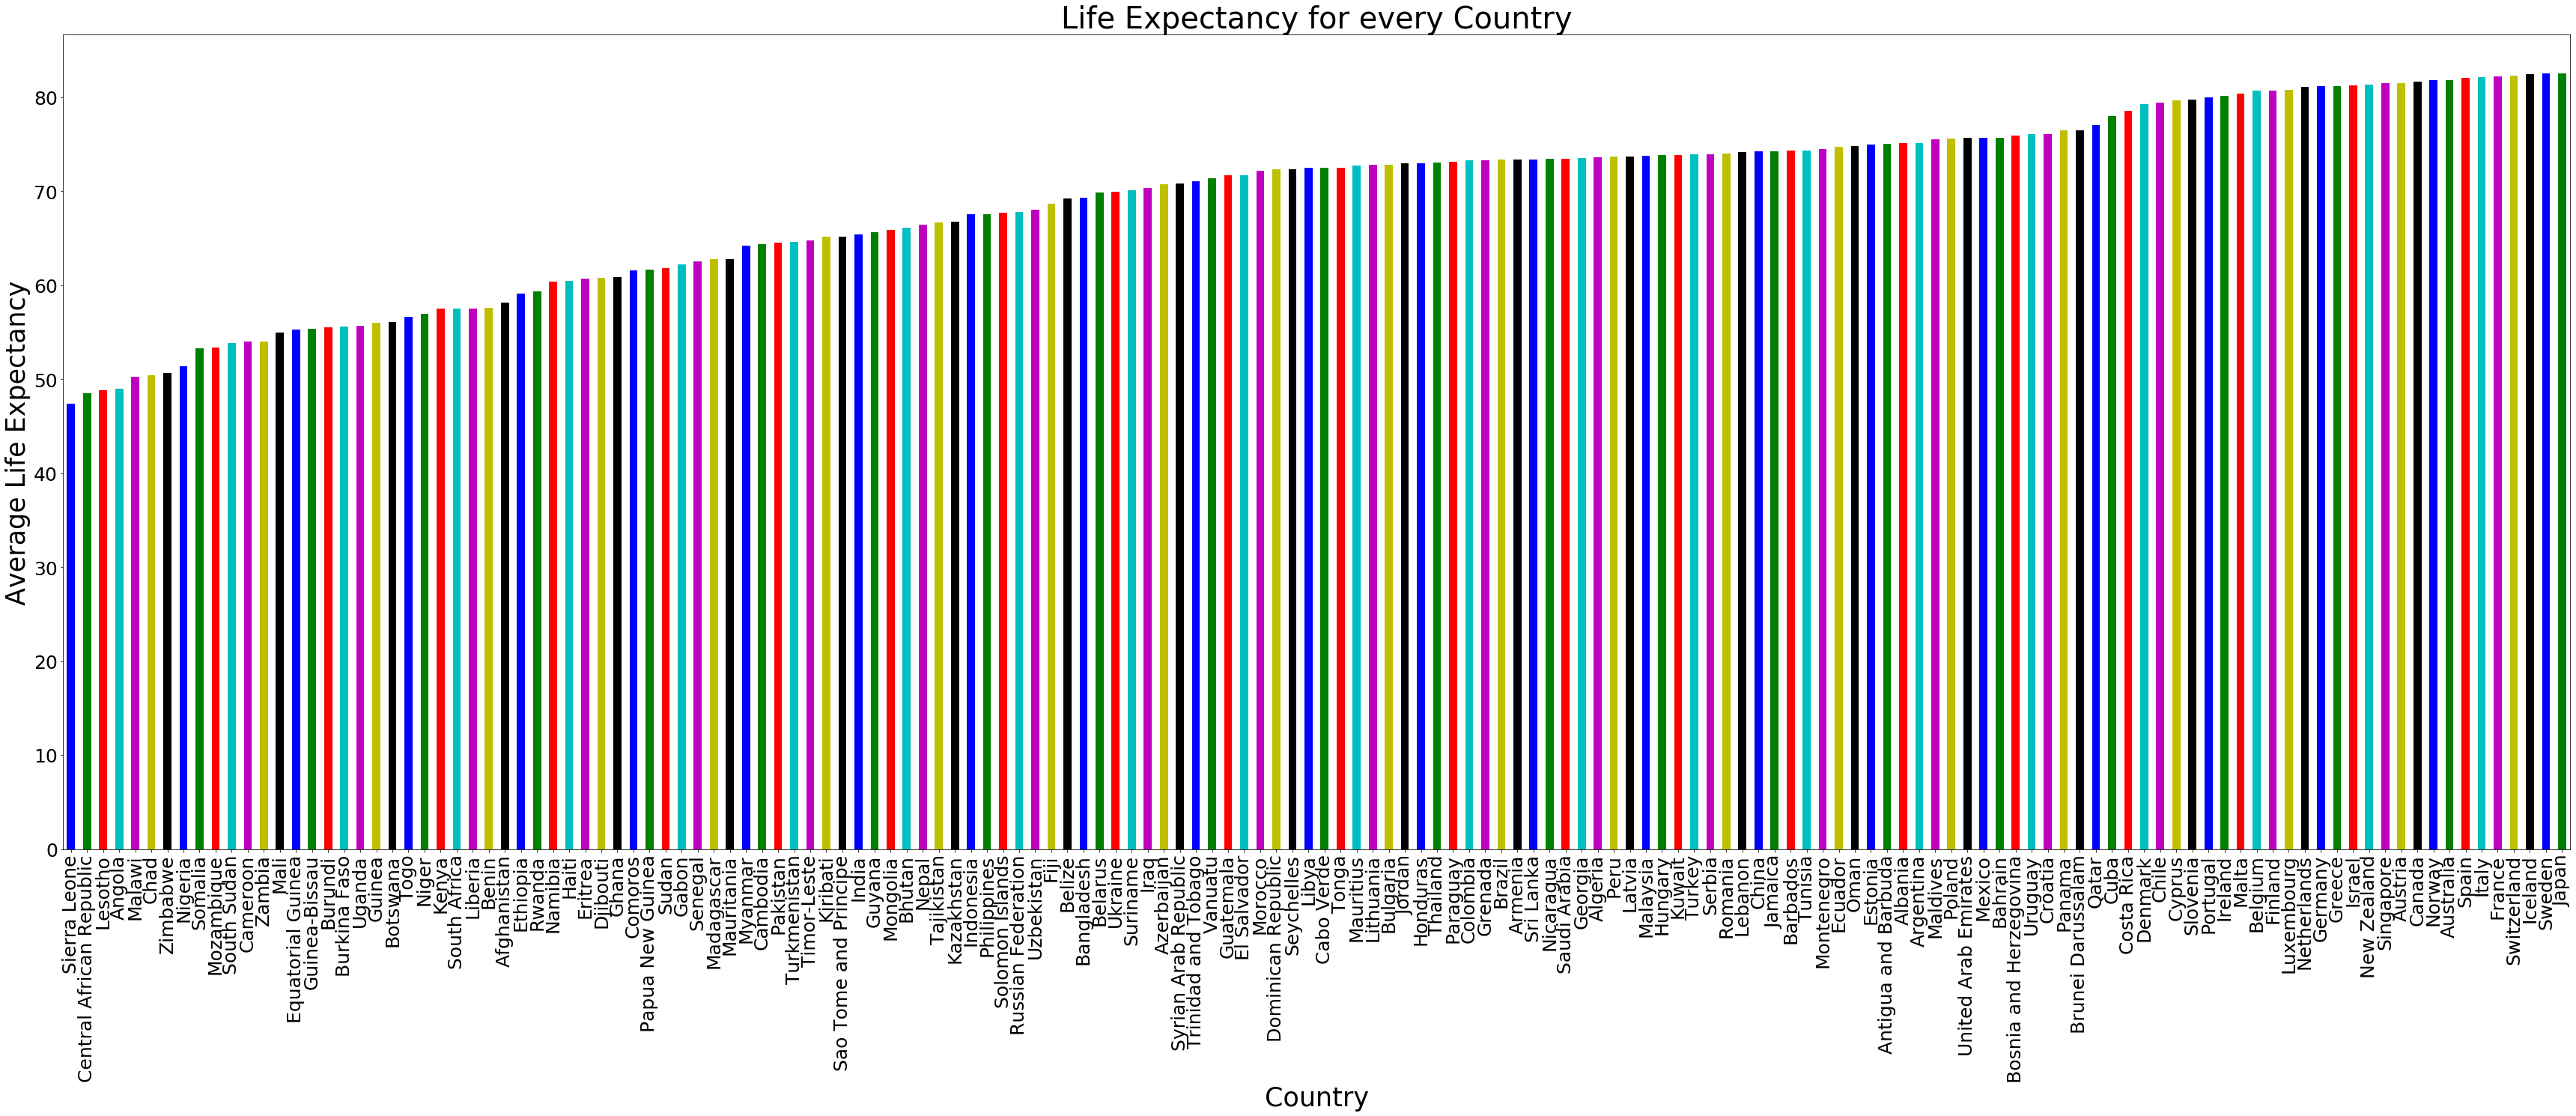

In [41]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
LifeExpCountry = winsorizedImputedFeats.groupby('Country')['Life expectancy '].mean().sort_values()
LifeExpCountry.plot(kind='bar', figsize=(60,20), fontsize=25, color = colors )
plt.title("Life Expectancy for every Country",fontsize=40)
plt.xlabel("Country",fontsize=35)
plt.ylabel("Average Life Expectancy",fontsize=35)
plt.show()



##### Lifespan values have a lot of variance. Patterns are going to be investigated.

#### Life expectancy plots for every region from 2000 to 2015

In [42]:
lifeExpRegionYear = pd.DataFrame(dfExp.groupby(['Region','Year'])['Life expectancy '].mean())
lifeExpRegionYear.reset_index(inplace = True) 
axAfrica = lifeExpRegionYear.loc[lifeExpRegionYear['Region'] =='Africa']
axAmericas = lifeExpRegionYear.loc[lifeExpRegionYear['Region'] =='Americas']
axAsia = lifeExpRegionYear.loc[lifeExpRegionYear['Region'] =='Asia']
axEurope = lifeExpRegionYear.loc[lifeExpRegionYear['Region'] =='Europe']
axOceania = lifeExpRegionYear.loc[lifeExpRegionYear['Region'] =='Oceania']

(array([1998., 2000., 2002., 2004., 2006., 2008., 2010., 2012., 2014.,
        2016.]), <a list of 10 Text xticklabel objects>)

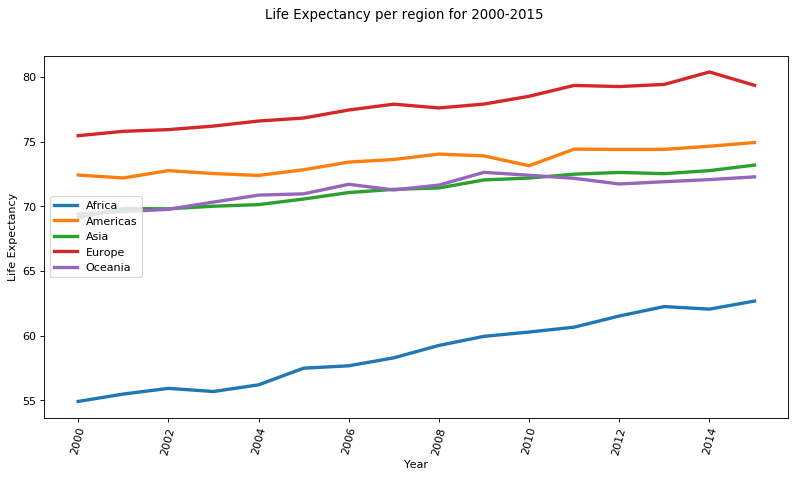

In [43]:
plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.suptitle('Life Expectancy per region for 2000-2015')
plt.plot(axAfrica['Year'], axAfrica['Life expectancy '], label='Africa', linewidth=3)
plt.plot(axAmericas['Year'], axAmericas['Life expectancy '], label='Americas', linewidth=3)
plt.plot(axAsia['Year'], axAsia['Life expectancy '], label='Asia', linewidth=3)
plt.plot(axEurope['Year'], axEurope['Life expectancy '], label='Europe', linewidth=3)
plt.plot(axOceania['Year'], axOceania['Life expectancy '], label='Oceania', linewidth=3)
plt.legend(loc='center left')
plt.xticks(rotation=75)

##### Africa has the most robust increase in it's life expectancy throughout the years, yet it's average lifespan is still about 8 years lower than Oceania's. We can see that we have three groups. Europe is the first one (highest life expectancy), Americas, Asia and Oceania follow in the second group and lastly Africa with the third group (lowest life expectancy).

#### Barplot with the percentage of change of life expectancy (year 2000) to life expectancy (year 2015 ) for every country

In [44]:
LifeExp2000LifeExp2015 = pd.DataFrame(winsorizedImputedFeats.groupby([('Country')], sort=False).apply(lambda x: (x['Life expectancy '].values[0] - x['Life expectancy '].values[-1]) / (x['Life expectancy '].values[0])))
LifeExp2000LifeExp2015.reset_index(level=0, inplace=True)
LifeExp2000LifeExp2015.rename(columns={ LifeExp2000LifeExp2015.columns[1]: 'LifeExpChange'}, inplace = True)

In [45]:
x, y = (list(x) for x in zip(*sorted(zip(LifeExp2000LifeExp2015['LifeExpChange'], LifeExp2000LifeExp2015['Country']), 
                                                          reverse = True)))

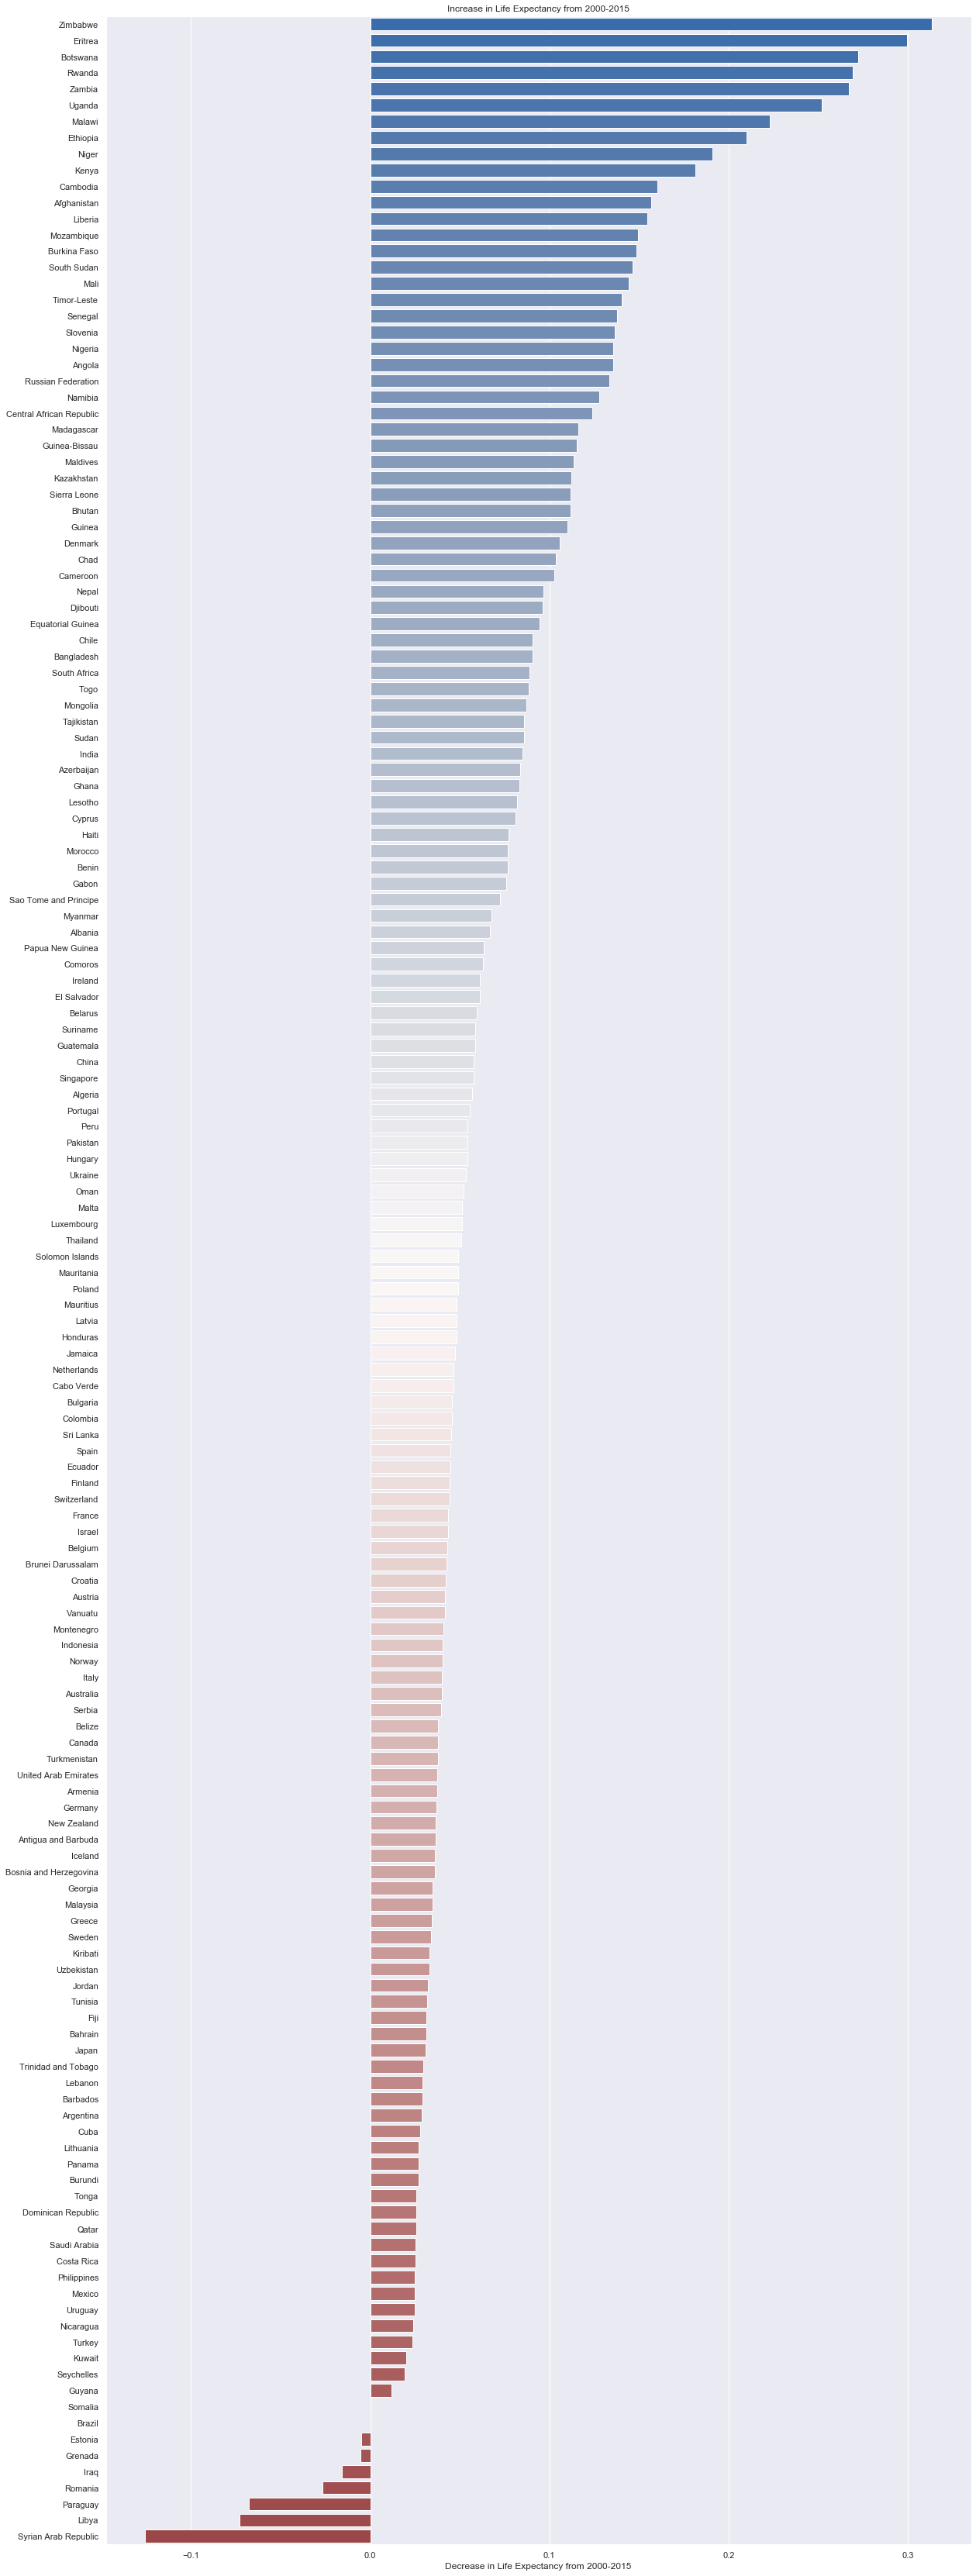

In [46]:
sns.set(font_scale=1) 
f, ax = plt.subplots(figsize=(20, 60))
sns.barplot(x, y, palette="vlag")
Text = ax.set(xlabel='Decrease in Life Expectancy from 2000-2015', 
              title='Increase in Life Expectancy from 2000-2015')

##### Most of the countries's life expectancy has increased except for 6. Unfortunatelly, it is important to mention that the biggest decrease for these 15 years, almost double from the previous one, belongs to Syria, because of the Syrian war that started in 2011 and continious until now.

In [47]:
lifeExpSyria = winsorizedImputedFeats[winsorizedImputedFeats['Country'] == 'Syrian Arab Republic']

[Text(0, 0.5, 'Life Expectancy'),
 Text(0.5, 0, 'Years'),
 Text(0.5, 1.0, 'Syrian Arab Republic')]

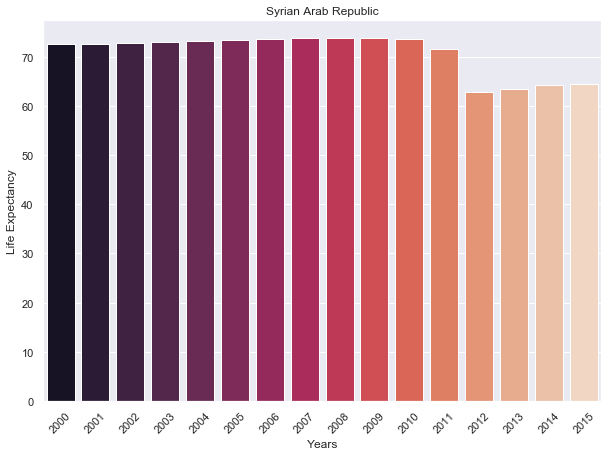

In [48]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(x = lifeExpSyria['Year'], y = lifeExpSyria['Life expectancy '], palette="rocket")
plt.xticks(rotation = 45)
ax.set(xlabel='Years', ylabel = 'Life Expectancy', title='Syrian Arab Republic')

##### This figure shows the average life expectancy in Syria from 2000-2015. During the year 2011-2012 this average dropped almost 10 years. This is an intersting and at the same time a very sad finding, that feels it has to be mentioned.

## 2.5 Developed/developing countries exploration

#### Developed and developing countries's life expectancy

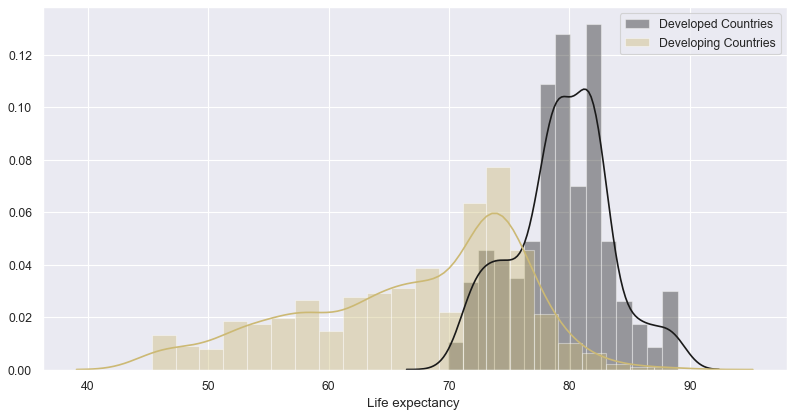

In [49]:
plt.figure(figsize=(12, 6), dpi=80)
sns.distplot(winsorizedImputedFeats[winsorizedImputedFeats['Status']=='Developed']['Life expectancy '], color = 'k')
sns.distplot(winsorizedImputedFeats[winsorizedImputedFeats['Status']=='Developing']['Life expectancy '],color='y')
labels=['Developed Countries','Developing Countries']
plt.legend(labels=labels,bbox_to_anchor=(1, 1))
plt.show()

In [50]:
developedCountries = winsorizedImputedFeats[winsorizedImputedFeats['Status'] == 'Developed']
developingCountries = winsorizedImputedFeats[winsorizedImputedFeats['Status'] == 'Developing']

#### Clearer visualization of the above

In [51]:
figure = {'data': [{'x': developedCountries['Status'], 
        'y': developedCountries['Life expectancy '], 'text': developedCountries['Country'], 'mode': 'markers', 'name': 'Developed Countries'},
        {'x': developingCountries['Status'], 'y': developingCountries['Life expectancy '], 'text': developingCountries['Country'], 'mode': 'markers', 'name': 'Developing Countries'}],
       'layout': {'xaxis': {'title': 'Status'}, 'yaxis': {'title': "Life Expectancy"}}}
plotly.offline.iplot(figure)

##### It is obvious that the economic status of a country doesn't represent accurately the longevity of each country. Meaning, that a lot of countries considered developing have the same life expectancy with developed countries after the age of 69.9, as we see in the above figure. This is why a new feature will be created in the 2.6 section, in order to group countries according to their life expectancy.

In [52]:
developedMeanLifExp = pd.DataFrame(developedCountries.groupby('Year').apply(lambda x: ((x['Life expectancy '].pct_change(periods = 1)).mean())))
developedMeanLifExp.reset_index(level=0, inplace=True)
developedMeanLifExp.rename(columns={developedMeanLifExp.columns[1]: 'LifeExpChange'}, inplace = True)

In [53]:
developingMeanLifExp = pd.DataFrame(developingCountries.groupby('Year').apply(lambda x: ((x['Life expectancy '].pct_change(periods = 1)).mean())))
developingMeanLifExp.reset_index(level=0, inplace=True)
developingMeanLifExp.rename(columns={developingMeanLifExp.columns[1]: 'LifeExpChange'}, inplace = True)

#### Barplots for life expectancy, adult mortality, income and schooling for developed and developing countries

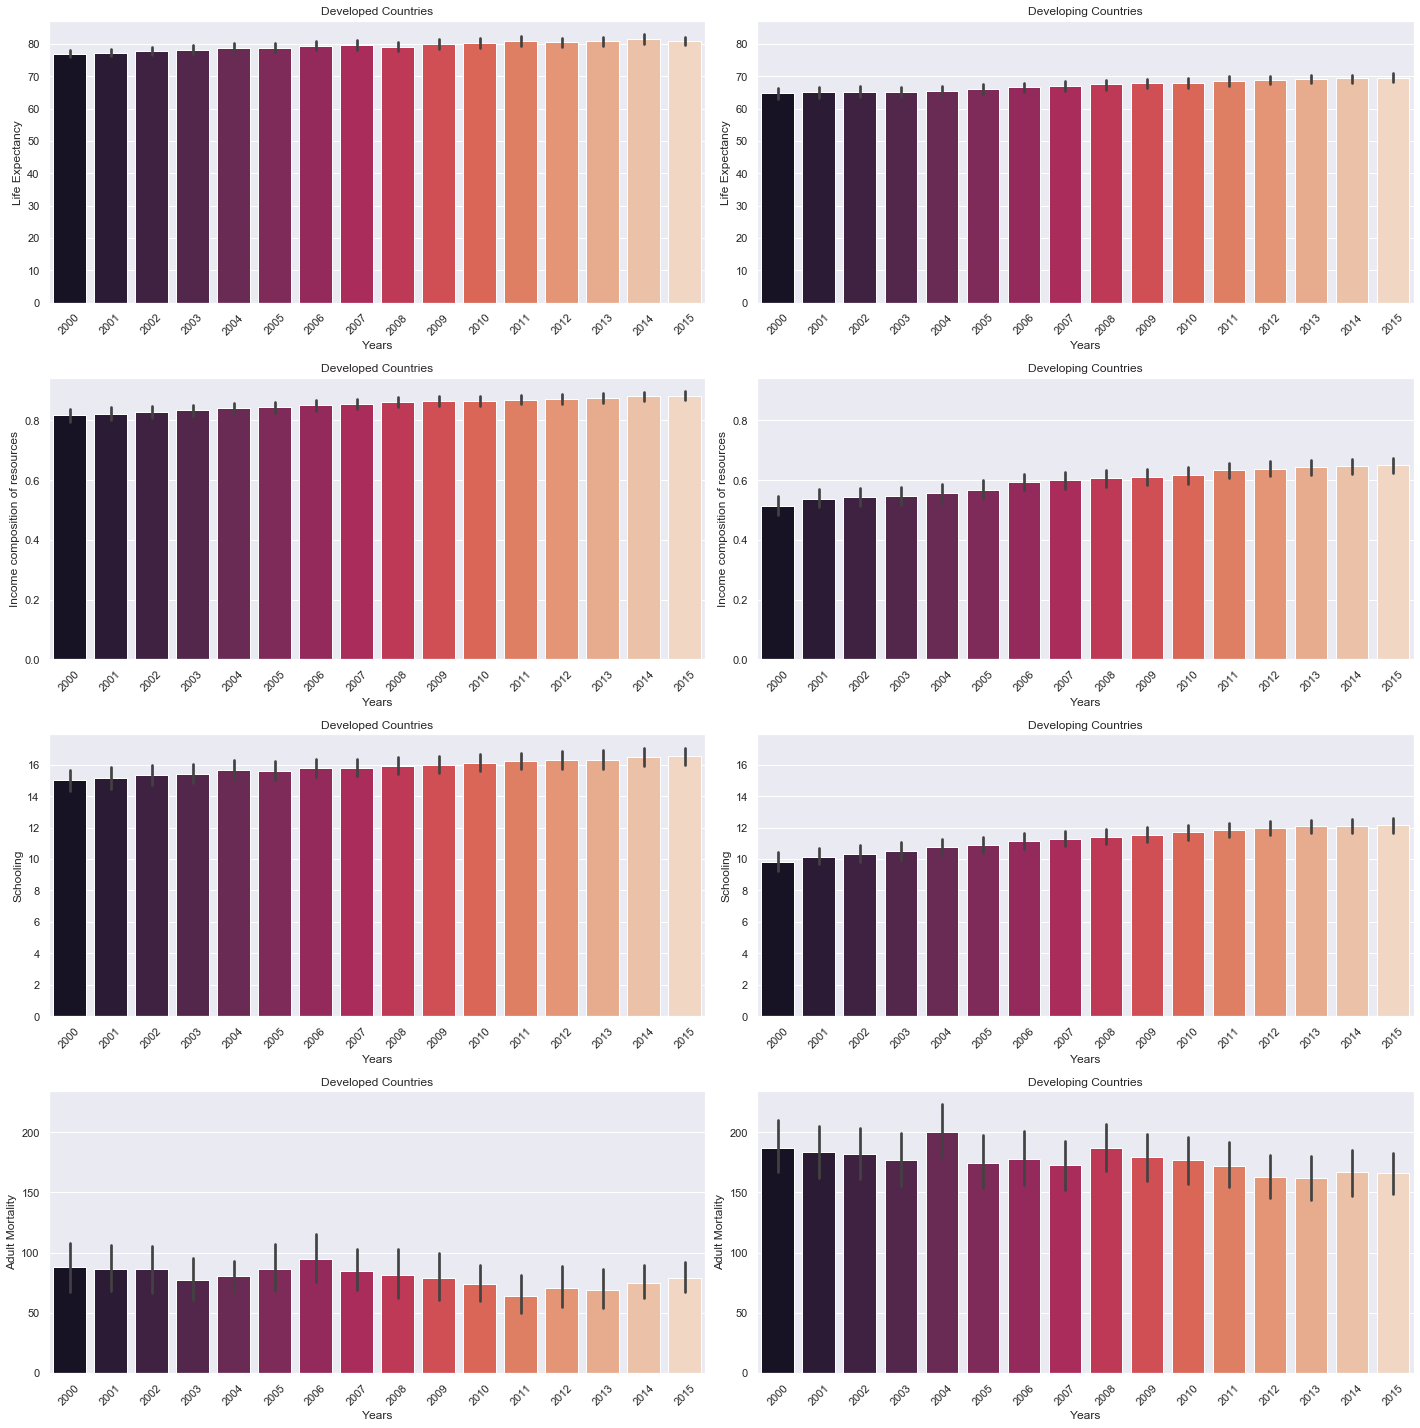

In [54]:
# Life expectancy
plt.figure(figsize=(20, 20))
plt.subplot(4, 2, 1)
plt.tight_layout()
ax1 = sns.barplot(x = developedCountries['Year'], y = developedCountries['Life expectancy '], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Life Expectancy', title='Developed Countries')

plt.subplot(4, 2, 2, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = developingCountries['Year'], y = developingCountries['Life expectancy '], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Life Expectancy', title='Developing Countries')

# Income composition of resources
plt.subplot(4, 2, 3)
plt.tight_layout()
ax1 = sns.barplot(x = developedCountries['Year'], y = developedCountries['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Income composition of resources', title='Developed Countries')

plt.subplot(4, 2, 4, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = developingCountries['Year'], y = developingCountries['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Income composition of resources', title='Developing Countries')

# Schooling
plt.subplot(4, 2, 5)
plt.tight_layout()
sns.set(font_scale = 1) 
ax1 = sns.barplot(x = developedCountries['Year'], y = developedCountries['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Schooling', title='Developed Countries')

plt.subplot(4, 2, 6, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = developingCountries['Year'], y = developingCountries['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Schooling', title='Developing Countries')

# Adult Mortality
plt.subplot(4, 2, 7)
plt.tight_layout()
ax1 = sns.barplot(x = developedCountries['Year'], y = developedCountries['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Adult Mortality', title='Developed Countries')

plt.subplot(4, 2, 8, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = developingCountries['Year'], y = developingCountries['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Adult Mortality', title='Developing Countries')

##### Although life expectancy, income and schooling increase by time for both kind of countries, adult mortality has ups and downs, but over time it is stable.

#### Change in life expectancy for developed and developing countries for the years 2000-2015

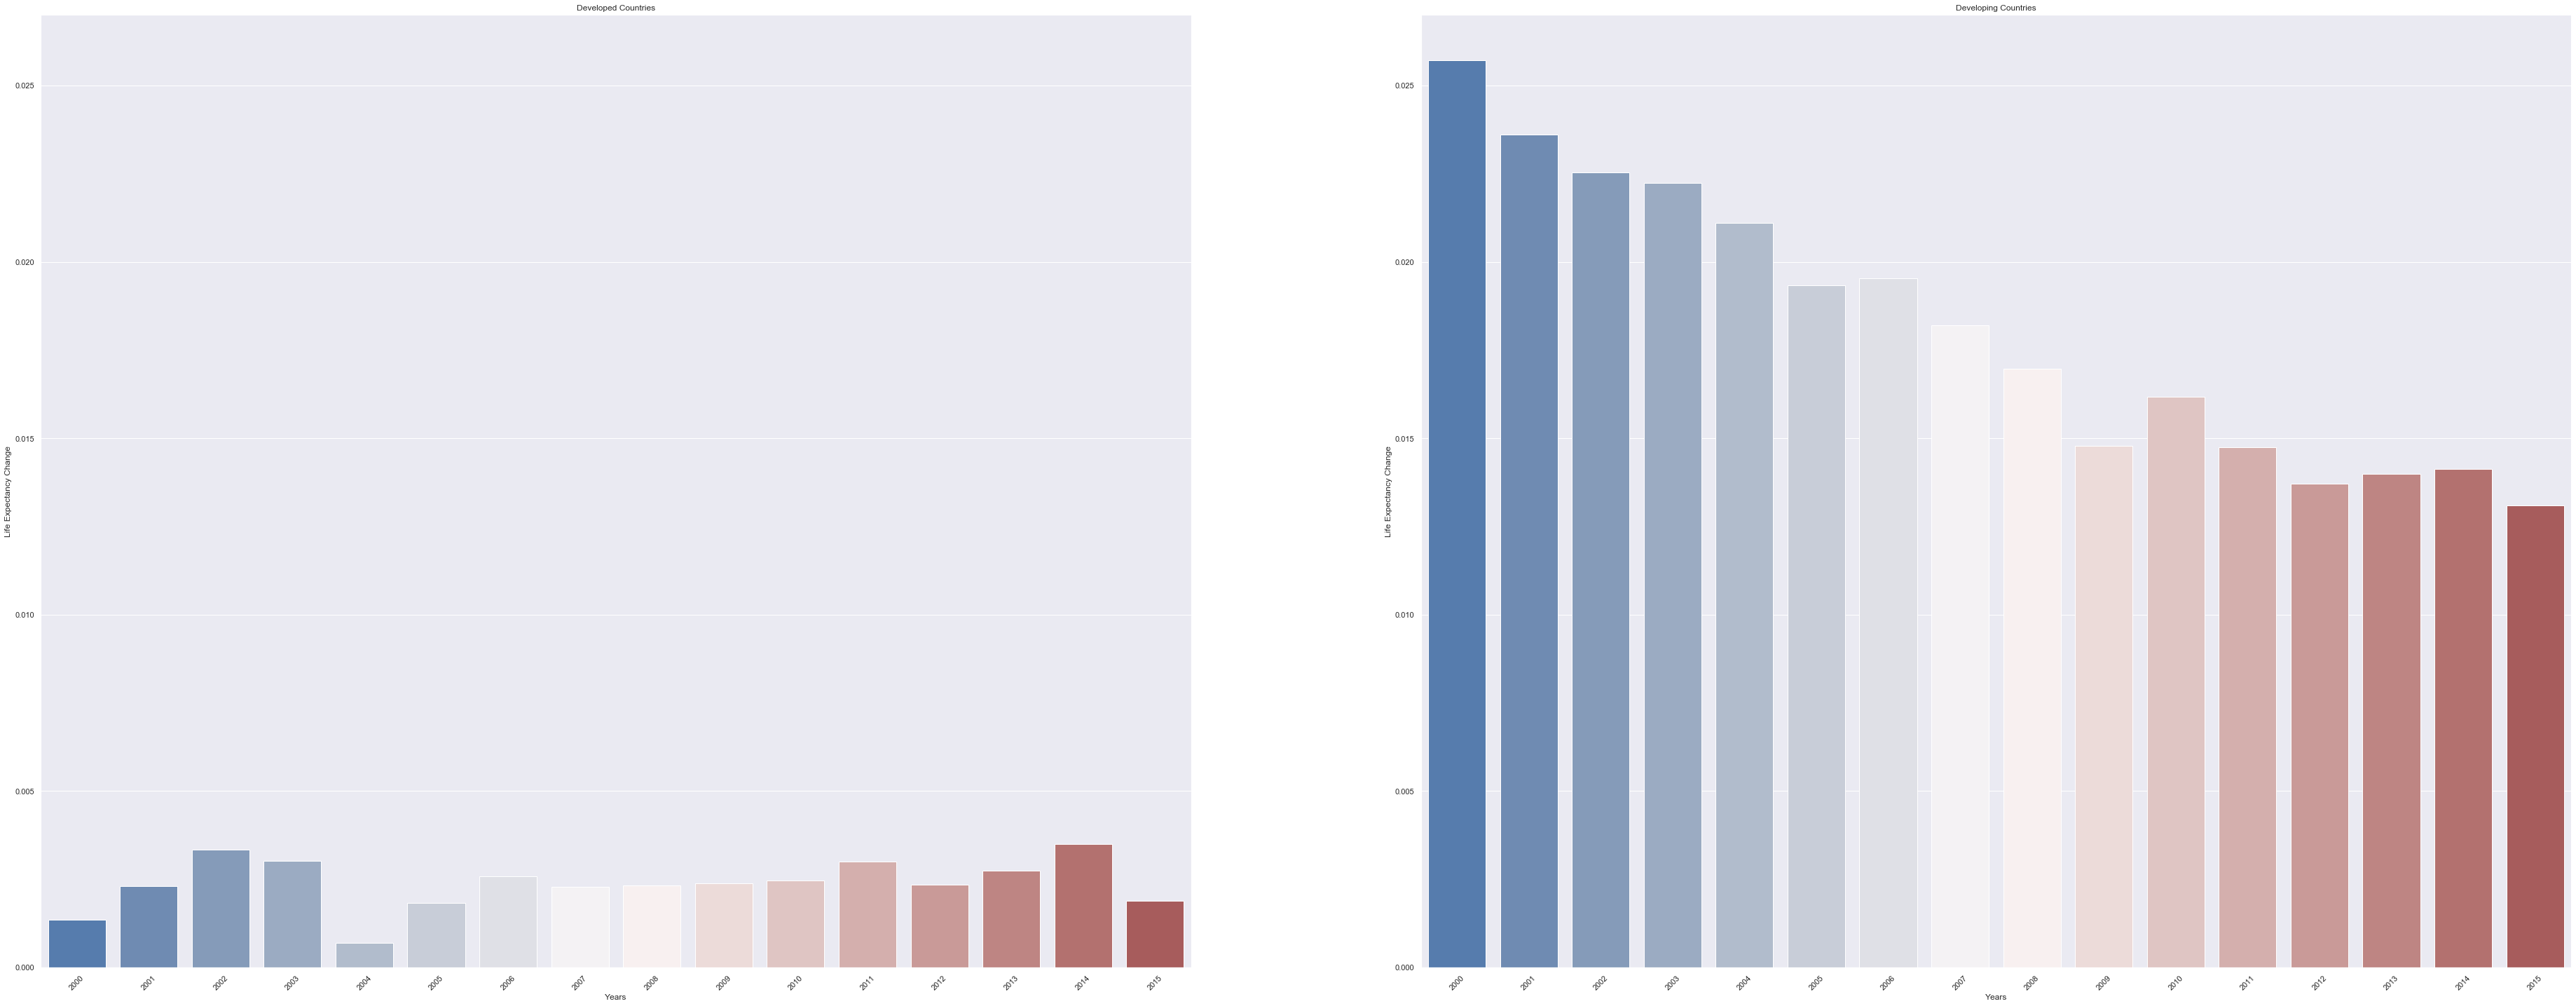

In [55]:
plt.figure(figsize=(100, 25))
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x = developedMeanLifExp['Year'], y = developedMeanLifExp['LifeExpChange'], palette="vlag")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Life Expectancy Change', title='Developed Countries')

plt.subplot(1, 3, 2, sharey = ax1)
ax2 = sns.barplot(x = developingMeanLifExp['Year'], y = developingMeanLifExp['LifeExpChange'], palette="vlag")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Life Expectancy Change', title='Developing Countries')


##### Huge differences in this figure. Developing countries have an increased life expectancy as high as 6 times higher than developed countries's.

Text(0.5, 0.92, 'DEVELOPING')

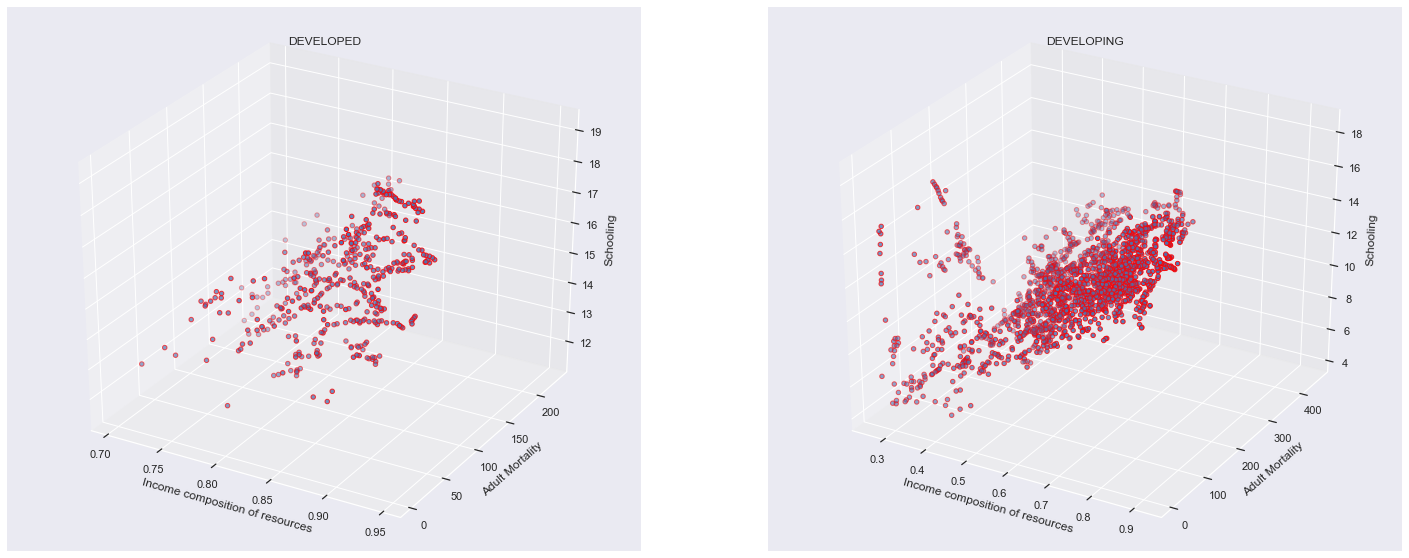

In [56]:
fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot(121, projection='3d')
ax1.scatter(developedCountries['Income composition of resources'], developedCountries['Adult Mortality'], developedCountries['Schooling'], edgecolors="red")
ax1.set_xlabel('Income composition of resources')
ax1.set_ylabel('Adult Mortality')
ax1.set_zlabel('Schooling')
ax1.set_title('DEVELOPED')

ax2 = plt.subplot(122, projection='3d')
ax2.scatter(developingCountries['Income composition of resources'], developingCountries['Adult Mortality'], developingCountries['Schooling'], edgecolors="red")
ax2.set_xlabel('Income composition of resources')
ax2.set_ylabel('Adult Mortality')
ax2.set_zlabel('Schooling')
ax2.set_title('DEVELOPING')


##### This figure shows the relationship of these 3 features for every status, in a 3D scatter plot.

In [57]:
winsorizedImputedFeats['Life expectancy '].groupby(winsorizedImputedFeats['Status']).describe()

count       mean       std   min     25%   50%   75%   max
Status                                                                 
Developed    448.0  79.427009  4.015664  69.9  77.075  79.6  82.0  89.0
Developing  2048.0  67.117529  9.018761  45.3  61.000  69.1  74.1  89.0

## 2.6 Further grouping of countries based on their life expectancy

#### Manually created groups of countries based on life expectancy

In [58]:
bins = [40, 55, 70, 90]
classes = [3,2,1]
winsorizedImputedSelectedFeats['World class'] = pd.cut(winsorizedImputedSelectedFeats['Life expectancy '], bins=bins, labels = classes)
winsorizedImputedFeats['World class'] = pd.cut(winsorizedImputedSelectedFeats['Life expectancy '], bins=bins, labels = classes)
winsorizedImputedCNumSelectedFeats = winsorizedImputedSelectedFeats.select_dtypes(include=[np.number])

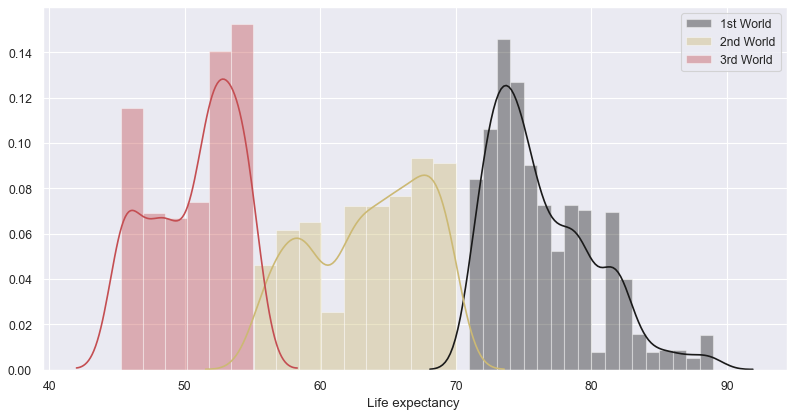

In [59]:
plt.figure(figsize=(12, 6), dpi=80)
sns.distplot(winsorizedImputedSelectedFeats[winsorizedImputedSelectedFeats['World class'] == 1]['Life expectancy '], color = 'k')
sns.distplot(winsorizedImputedSelectedFeats[winsorizedImputedSelectedFeats['World class'] == 2]['Life expectancy '], color = 'y')
sns.distplot(winsorizedImputedSelectedFeats[winsorizedImputedSelectedFeats['World class'] == 3]['Life expectancy '], color = 'r')
labels=['1st World','2nd World', '3rd World']
plt.legend(labels=labels,bbox_to_anchor=(1, 1))
plt.show()

## 2.7 First/Second/Third World Class exporation

#### How world classes are distributed via a QQ plot

(0.9561380743980408, 8.879353637921577e-27)
(0.9561380743980408, 8.879353637921577e-27)
(0.9561380743980408, 8.879353637921577e-27)


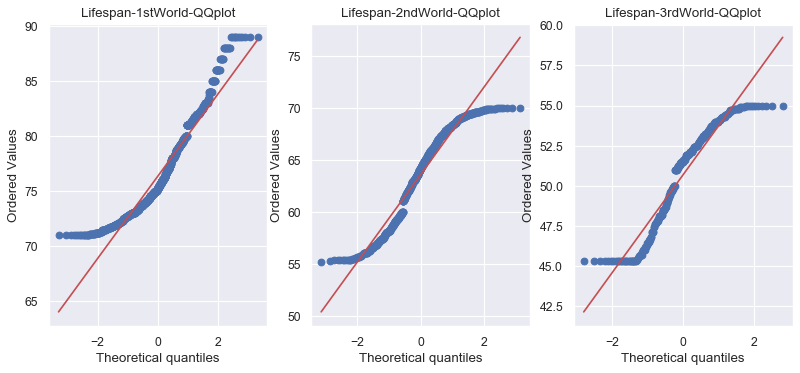

In [60]:
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(131)
stats.probplot(winsorizedImputedSelectedFeats[winsorizedImputedSelectedFeats['World class'] == 1]['Life expectancy '], dist="norm", plot=plt)
plt.title('Lifespan-1stWorld-QQplot')
print(stats.shapiro(winsorizedImputedSelectedFeats['Life expectancy ']))
plt.subplot(132)
stats.probplot(winsorizedImputedSelectedFeats[winsorizedImputedSelectedFeats['World class'] == 2]['Life expectancy '], dist="norm", plot=plt)
plt.title('Lifespan-2ndWorld-QQplot')
print(stats.shapiro(winsorizedImputedSelectedFeats['Life expectancy ']))
plt.subplot(133)
stats.probplot(winsorizedImputedSelectedFeats[winsorizedImputedSelectedFeats['World class'] == 3]['Life expectancy '], dist="norm", plot=plt)
plt.title('Lifespan-3rdWorld-QQplot')
print(stats.shapiro(winsorizedImputedSelectedFeats['Life expectancy ']))


#### Which regions constitute each World Class

In [61]:
figure = {"data": [{"values":  [len(winsorizedImputedFeats[(winsorizedImputedFeats['Region'] =='Asia' ) & (winsorizedImputedFeats['World class'] == 1)]), 
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Europe') & (winsorizedImputedFeats["World class"] == 1)]),
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Africa') & (winsorizedImputedFeats["World class"] == 1)]),
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Americas') & (winsorizedImputedFeats["World class"] == 1)]),
                    len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Oceania') & (winsorizedImputedFeats["World class"] == 1)])],
      "labels" : ['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'],
      "domain": {"x": [0, 0.33]},
      "name": "First World",
      "hoverinfo":"label+percent+name",
      "hole": 0.25,
      "type": "pie"
    }, {"values":  [len(winsorizedImputedFeats[(winsorizedImputedFeats['Region'] =='Asia' ) & (winsorizedImputedFeats['World class'] == 2)]), 
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Europe') & (winsorizedImputedFeats["World class"] == 2)]),
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Africa') & (winsorizedImputedFeats["World class"] == 2)]),
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Americas') & (winsorizedImputedFeats["World class"] == 2)]),
                    len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Oceania') & (winsorizedImputedFeats["World class"] == 2)])],
      "labels" : ['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'],
      "domain": {"x": [0.34, 0.66]},
      "name": "Second World",
      "hoverinfo":"label+percent+name",
      "hole": 0.25,
      "type": "pie"},
                   {"values":  [len(winsorizedImputedFeats[(winsorizedImputedFeats['Region'] =='Asia' ) & (winsorizedImputedFeats['World class'] == 3)]), 
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Europe') & (winsorizedImputedFeats["World class"] == 3)]),
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Africa') & (winsorizedImputedFeats["World class"] == 3)]),
                  len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Americas') & (winsorizedImputedFeats["World class"] == 3)]),
                    len(winsorizedImputedFeats[(winsorizedImputedFeats["Region"] == 'Oceania') & (winsorizedImputedFeats["World class"] == 3)])],
      "labels" : ['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'],
      "domain": {"x": [0.67, 1]},
      "name": "Third World",
      "hoverinfo":"label+percent+name",
      "hole": 0.25,
      "type": "pie"}],
          "layout": {
        "title":"Percentage of each region for every World class",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "First World Countries",
                "x": 0,
                "y": 0
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Second World Countries",
                "x": 0.5,
                "y": 0
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Third World Countries",
                "x": 1,
                "y": 0
            }
        ]
}
         }

plotly.offline.iplot(figure, filename='donut')
                   

#### We create a dataframe for each world class

In [62]:
firstWorldCountries = winsorizedImputedFeats[winsorizedImputedFeats['World class'] == 1]
secondWorldCountries = winsorizedImputedFeats[winsorizedImputedFeats['World class'] == 2]
thirdWorldCountries = winsorizedImputedFeats[winsorizedImputedFeats['World class'] == 3]

Text(0.5, 0.92, 'THIRD WORLD')

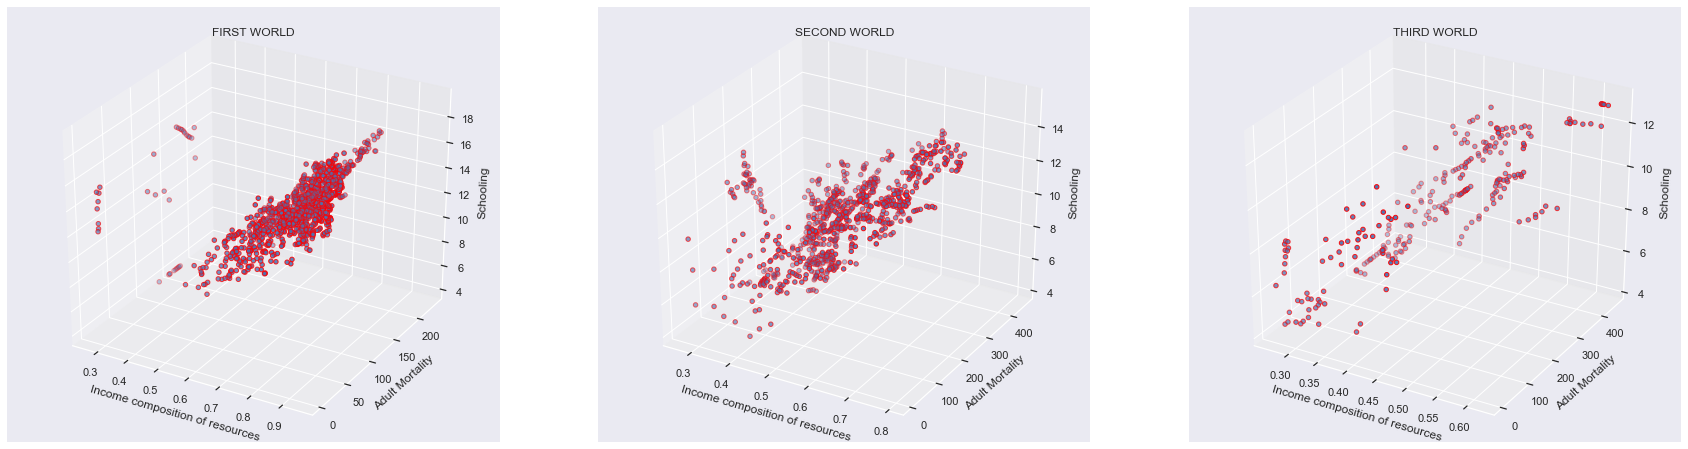

In [63]:
fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(131, projection='3d')
ax1.scatter(firstWorldCountries['Income composition of resources'], firstWorldCountries['Adult Mortality'], firstWorldCountries['Schooling'], edgecolors="red")
ax1.set_xlabel('Income composition of resources')
ax1.set_ylabel('Adult Mortality')
ax1.set_zlabel('Schooling')
ax1.set_title('FIRST WORLD')

ax2 = plt.subplot(132, projection='3d')
ax2.scatter(secondWorldCountries['Income composition of resources'], secondWorldCountries['Adult Mortality'], secondWorldCountries['Schooling'], edgecolors="red")
ax2.set_xlabel('Income composition of resources')
ax2.set_ylabel('Adult Mortality')
ax2.set_zlabel('Schooling')
ax2.set_title('SECOND WORLD')

ax3 = plt.subplot(133, projection='3d')
ax3.scatter(thirdWorldCountries['Income composition of resources'], thirdWorldCountries['Adult Mortality'], thirdWorldCountries['Schooling'], edgecolors="red")
ax3.set_xlabel('Income composition of resources')
ax3.set_ylabel('Adult Mortality')
ax3.set_zlabel('Schooling')
ax3.set_title('THIRD WORLD')

##### This figure shows the relationship of these 3 features for every world class, in a 3D scatter plot.

#### Barplots for life expectancy, adult mortality, income and schooling for all the world classes

In [64]:
FirstWCMeanLifExp = pd.DataFrame(firstWorldCountries.groupby('Year').apply(lambda x: ((x['Life expectancy '].pct_change(periods = 1)).mean())))
FirstWCMeanLifExp.reset_index(level=0, inplace=True)
FirstWCMeanLifExp.rename(columns={FirstWCMeanLifExp.columns[1]: 'LifeExpChange'}, inplace = True)

In [65]:
SecondWCMeanLifExp = pd.DataFrame(secondWorldCountries.groupby('Year').apply(lambda x: ((x['Life expectancy '].pct_change(periods = 1)).mean())))
SecondWCMeanLifExp.reset_index(level=0, inplace=True)
SecondWCMeanLifExp.rename(columns={ SecondWCMeanLifExp.columns[1]: 'LifeExpChange'}, inplace = True)

In [66]:
ThirdWCMeanLifExp = pd.DataFrame(thirdWorldCountries.groupby('Year').apply(lambda x: ((x['Life expectancy '].pct_change(periods = 1)).mean())))
ThirdWCMeanLifExp.reset_index(level=0, inplace=True)
ThirdWCMeanLifExp.rename(columns={ThirdWCMeanLifExp.columns[1]: 'LifeExpChange'}, inplace = True)

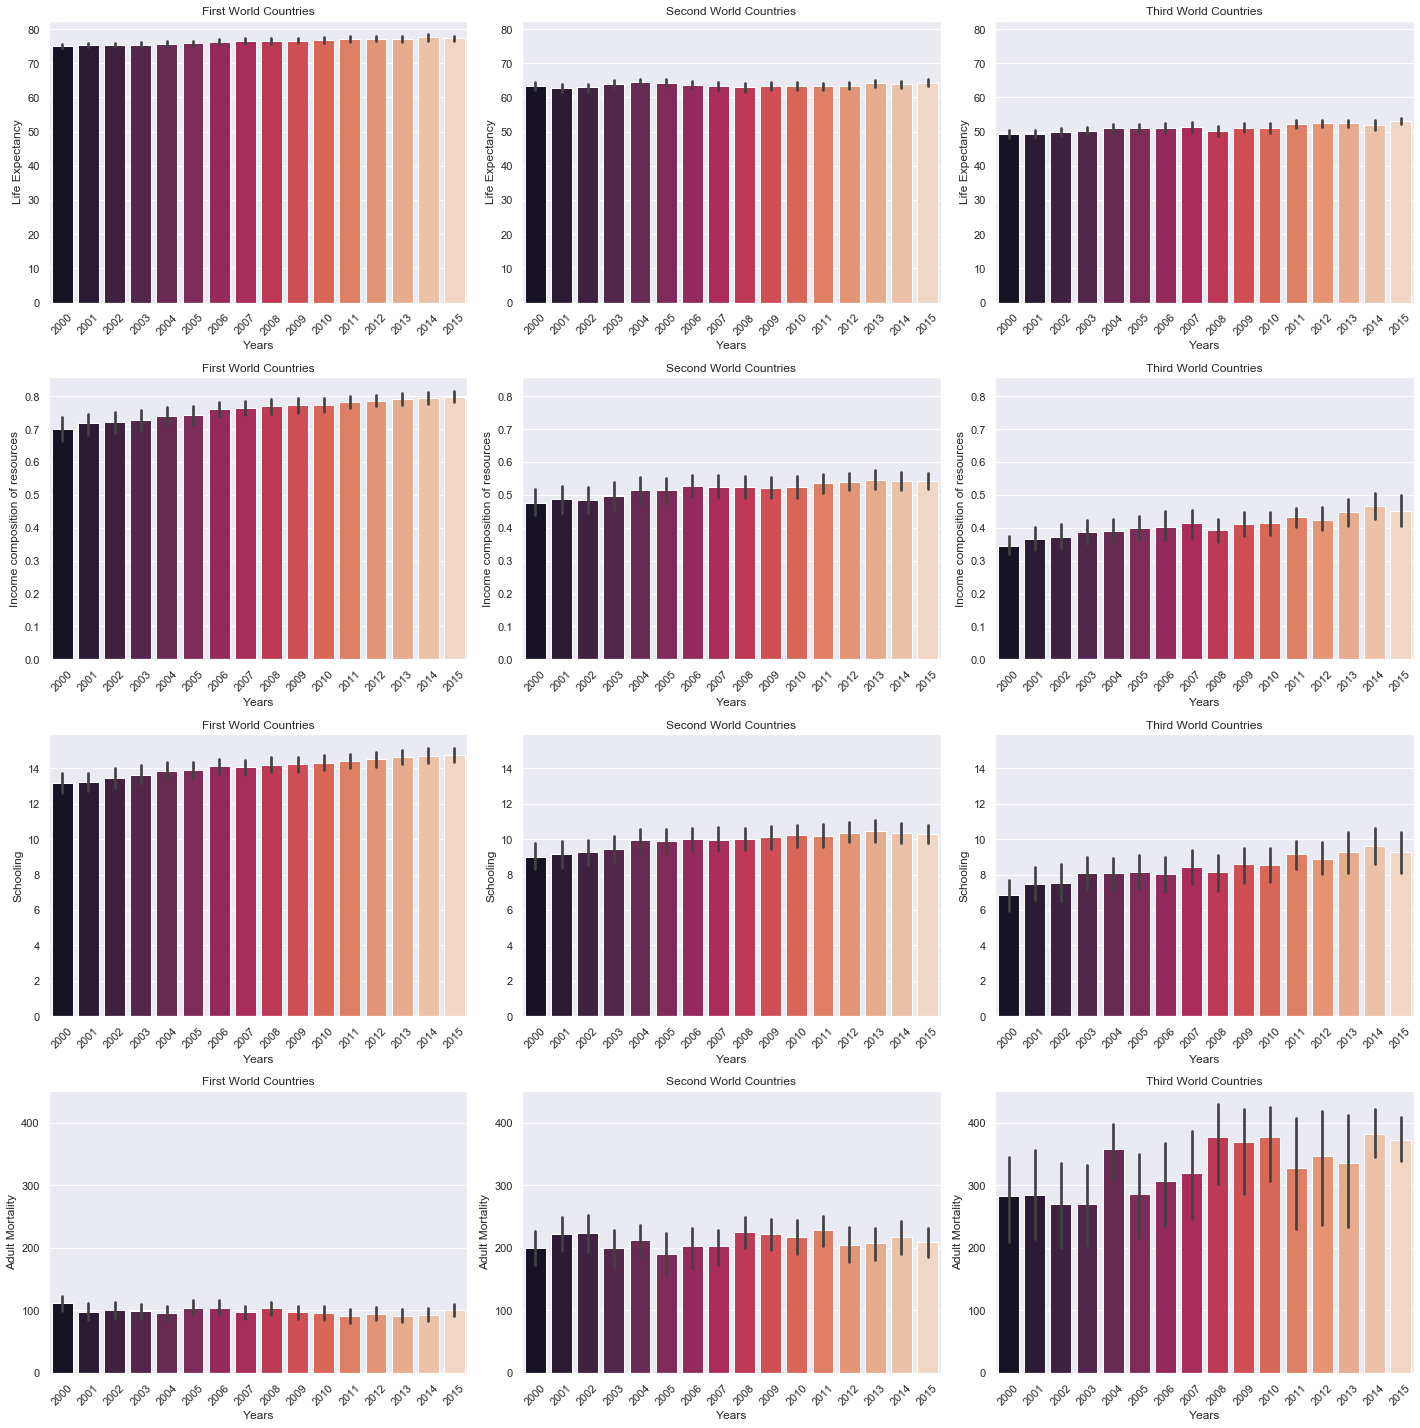

In [67]:
# Life expectancy
plt.figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
plt.tight_layout()
ax1 = sns.barplot(x = firstWorldCountries['Year'], y = firstWorldCountries['Life expectancy '], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Life Expectancy', title='First World Countries')

plt.subplot(4, 3, 2, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = secondWorldCountries['Year'], y = secondWorldCountries['Life expectancy '], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Life Expectancy', title='Second World Countries')

plt.subplot(4, 3, 3, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = thirdWorldCountries['Year'], y = thirdWorldCountries['Life expectancy '], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Life Expectancy', title='Third World Countries')
# Income composition of resources
plt.subplot(4, 3, 4)
plt.tight_layout()
ax1 = sns.barplot(x = firstWorldCountries['Year'], y = firstWorldCountries['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Income composition of resources', title='First World Countries')

plt.subplot(4, 3, 5, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = secondWorldCountries['Year'], y = secondWorldCountries['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Income composition of resources', title='Second World Countries')

plt.subplot(4, 3, 6, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = thirdWorldCountries['Year'], y = thirdWorldCountries['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Income composition of resources', title='Third World Countries')

# Schooling
plt.subplot(4, 3, 7)
plt.tight_layout()
ax1 = sns.barplot(x = firstWorldCountries['Year'], y = firstWorldCountries['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Schooling', title='First World Countries')

plt.subplot(4, 3, 8, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = secondWorldCountries['Year'], y = secondWorldCountries['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Schooling', title='Second World Countries')

plt.subplot(4, 3, 9, sharey = ax1)
plt.tight_layout()
ax1 = sns.barplot(x = thirdWorldCountries['Year'], y = thirdWorldCountries['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Schooling', title='Third World Countries')

# Adult Mortality
plt.subplot(4, 3, 10)
plt.tight_layout()
ax1 = sns.barplot(x = firstWorldCountries['Year'], y = firstWorldCountries['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Adult Mortality', title='First World Countries')

plt.subplot(4, 3, 11, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = secondWorldCountries['Year'], y = secondWorldCountries['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Adult Mortality', title='Second World Countries')

plt.subplot(4, 3, 12, sharey = ax1)
plt.tight_layout()
ax1 = sns.barplot(x = thirdWorldCountries['Year'], y = thirdWorldCountries['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Adult Mortality', title='Third World Countries')

##### An intersting thing to mention is that adult mortality in third world countries is not stable as in the other classes. It has increased, and maybe this is the reason why life expectancy in those countries hasn't increased all these years.

#### Change in life expectancy for the three world classes during the years 2000-2015

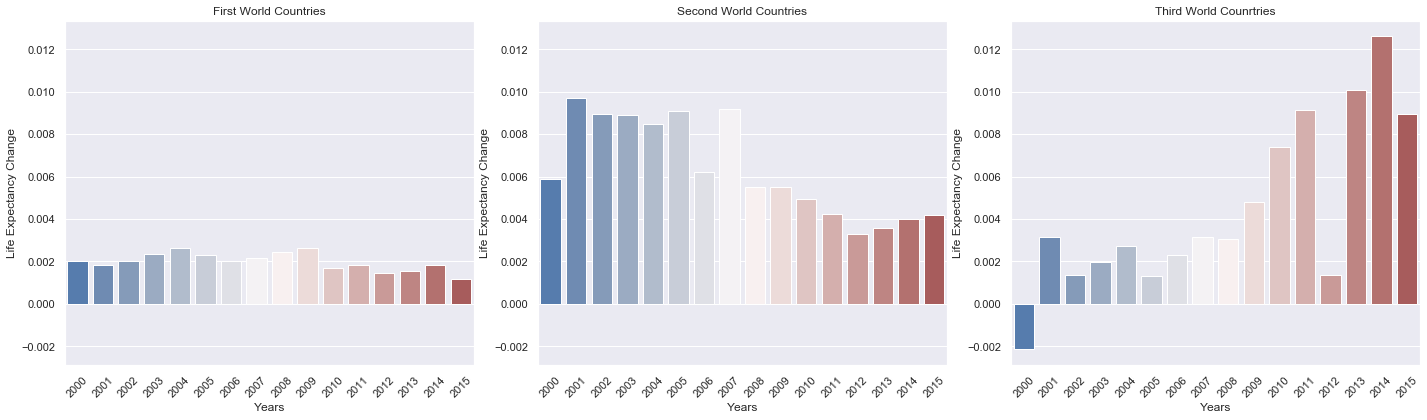

In [68]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.tight_layout()
ax1 = sns.barplot(x = FirstWCMeanLifExp['Year'], y = FirstWCMeanLifExp['LifeExpChange'], palette="vlag")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Life Expectancy Change', title='First World Countries')

plt.subplot(1, 3, 2, sharey = ax1)
plt.tight_layout()
ax2 = sns.barplot(x = SecondWCMeanLifExp['Year'], y = SecondWCMeanLifExp['LifeExpChange'], palette="vlag")
plt.xticks(rotation = 45)
Text = ax2.set(xlabel='Years', ylabel = 'Life Expectancy Change', title='Second World Countries')

plt.subplot(1, 3, 3, sharey = ax1)
plt.tight_layout()
ax3 = sns.barplot(x = ThirdWCMeanLifExp['Year'], y = ThirdWCMeanLifExp['LifeExpChange'], palette="vlag")
plt.xticks(rotation = 45)
Text = ax3.set(xlabel='Years', ylabel = 'Life Expectancy Change', title='Third World Counrtries')

##### Third world countries tend to icrease their life expectancy every year. Although, in 2012 we observe a huge decrease in life expectancy that is probably linked to tha conflicts in Syria that started that year.

# 3. Modeling

## 3.1 K-means Clustering

#### Columns that will be used for clustering

In [69]:
selectedCols = ['Life expectancy ', 'Adult Mortality', ' HIV/AIDS',
       'Income composition of resources', 'Schooling',
       'Sanitation Mortality/100000(2016)']
clusterData = winsorizedImputedSelectedFeats.loc[:,selectedCols]

#### Feature scaling because of the different magnitude that they have

In [70]:
scaler = StandardScaler()
clusterDataScaled = scaler.fit_transform(clusterData)

#### Test the model for different number of countries and different seeds

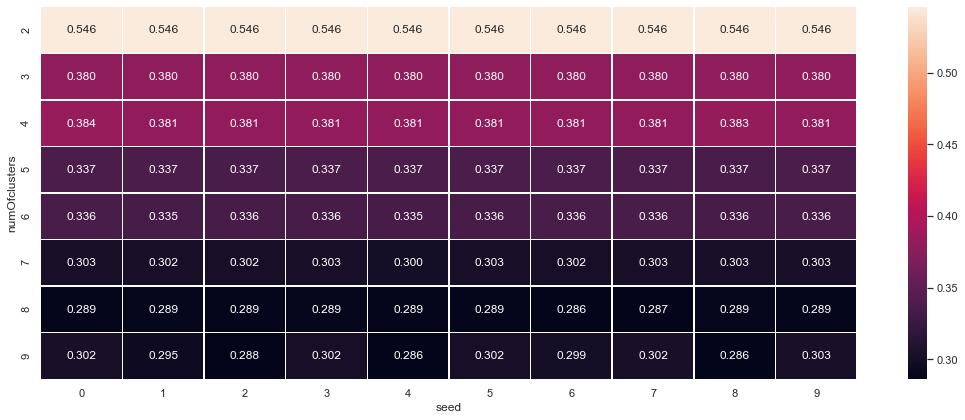

In [71]:
rangeOfClusters = range(2, 10)
randomSeedRange = range(0, 10)
scoreResults =[]
for c in rangeOfClusters:
    for r in randomSeedRange:
        clusterer = KMeans(n_clusters=c, random_state=r)
        clusterLabels = clusterer.fit_predict(clusterDataScaled)
        silhouetteAavg = silhouette_score(clusterDataScaled, clusterLabels)
        scoreResults.append([c,r,silhouetteAavg])


resultFinal = pd.DataFrame(scoreResults, columns=["numOfclusters","seed","silhouetteScore"])
pivotTable = pd.pivot_table(resultFinal, index="numOfclusters", columns="seed",values="silhouetteScore")

plt.figure(figsize=(15,6))
sns.heatmap(pivotTable, annot=True, linewidths=.5, fmt='.3f')
plt.tight_layout()

##### The optimal number of clusters is 2 as the highest silhouette average was succeded. The seed did not play any role.

#### Fitting the model with a number of clusters equals 2

In [72]:
kmeansSilh = KMeans(n_clusters=2, random_state=0).fit(clusterDataScaled)
labels = pd.DataFrame(kmeansSilh.labels_)
clusteredData = clusterData.assign(Cluster=labels)

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html?fbclid=IwAR3dLwC54yeAp4HgGRUCBvbRwun8a46sys3Hwm42SUjvkQCWHpPQXqisW0Y

#### Silhouette plots to visualize our clusters

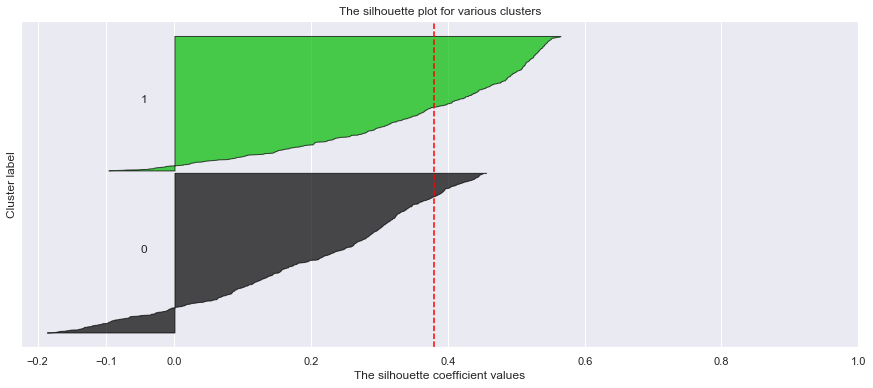

In [73]:
clusterer = KMeans(n_clusters=3, random_state=0)
clusterLabels = clusterer.fit_predict(clusterDataScaled)
silhouetteAavg = silhouette_score(clusterDataScaled, clusterLabels)
sampleSilhouetteValues = silhouette_samples(clusterDataScaled, clusterLabels)
fig, ax1 = plt.subplots(figsize=(15,6))
yLower = 10
for i in range(2):
    ith_cluster_silhouette_values = sampleSilhouetteValues[clusterLabels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    yUpper = yLower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 2)
    ax1.fill_betweenx(np.arange(yLower, yUpper),0, ith_cluster_silhouette_values, facecolor=color,
                      edgecolor="black", alpha=0.7)
    ax1.text(-0.05, yLower + 0.5 * size_cluster_i, str(i))
    yLower = yUpper + 10 

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouetteAavg, color="red", linestyle="--")
ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

##### Generally the silhouette plot can range from -1 to 1, but in our case it does not. That's why our figure goes down to -0.2.

In [74]:
groupedbyCluster = clusteredData.groupby(['Cluster']).mean().round(1)
groupedbyCluster

Life expectancy   Adult Mortality   HIV/AIDS  \
Cluster                                                 
0.0                  74.0            117.5        0.2   
1.0                  59.5            248.5        1.2   

         Income composition of resources  Schooling  \
Cluster                                               
0.0                                  0.7       13.5   
1.0                                  0.5        9.0   

         Sanitation Mortality/100000(2016)  
Cluster                                     
0.0                                    2.8  
1.0                                   28.0

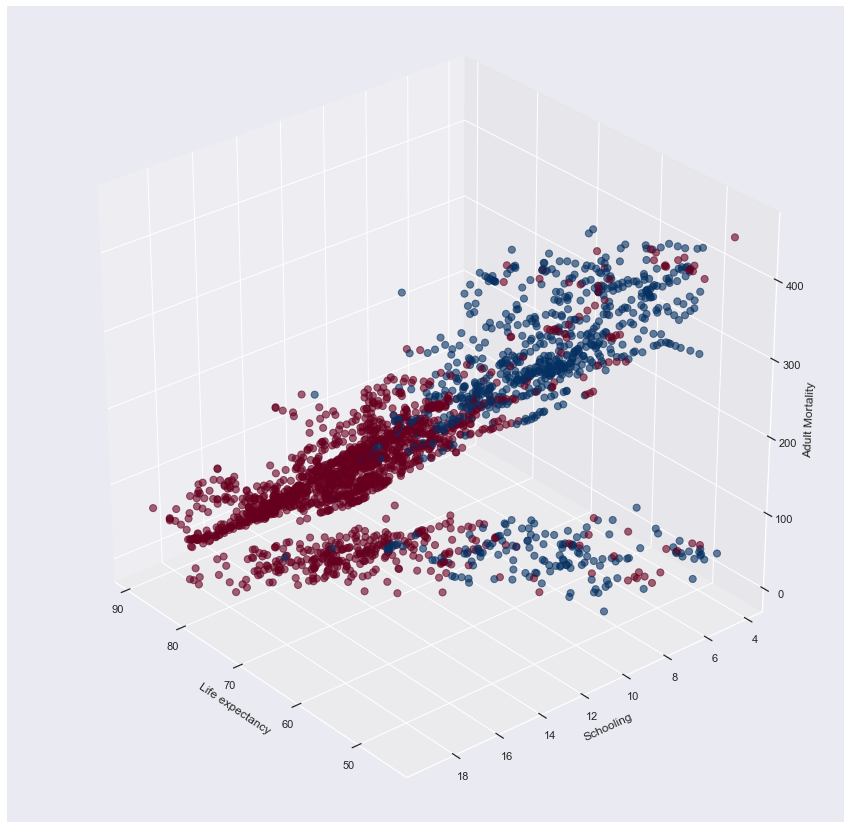

In [75]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
x = clusteredData['Life expectancy ']
y = clusteredData['Schooling']
z = clusteredData['Adult Mortality']
ax.scatter(x, y, z, c = clusteredData["Cluster"], s=50, alpha=0.6, cmap="RdBu")
ax.set_xlabel('Life expectancy')
ax.set_ylabel('Schooling')
ax.set_zlabel('Adult Mortality')
ax.view_init(30, 140)

##### We assign the column 'Cluster' of the above clustered dataframe to the main dataframe of our project.

In [76]:
 winsorizedImputedSelectedFeats = winsorizedImputedSelectedFeats.assign(Cluster=clusteredData['Cluster'].values)

## 3.2 Comparing classification algorithms

https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [77]:
X = winsorizedImputedSelectedFeats.iloc[:, 7:-1]
X.drop(X.tail(7).index,inplace=True)
Y = winsorizedImputedSelectedFeats.iloc[:,-1]
Y.drop(Y.tail(7).index,inplace=True)

#### Appending the models used to a list

In [78]:
seed = 42
listOfTestedModels = []
listOfTestedModels.append(('Logistic Reg', LogisticRegression()))
listOfTestedModels.append(('Linear Discr Anal', LinearDiscriminantAnalysis()))
listOfTestedModels.append(('K-NearestNeighbors', KNeighborsClassifier()))
listOfTestedModels.append(('Decision Tree', DecisionTreeClassifier()))
listOfTestedModels.append(('Naive Bayes', GaussianNB()))
listOfTestedModels.append(('Support Vector Machine', SVC()))

#### Running every algorithm

In [79]:
AccResults = []
algos = []
msg = []
for name, model in listOfTestedModels:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    CrossValResults = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    AccResults.append(CrossValResults)
    algos.append(name)
    msg.append((name, CrossValResults.mean(), CrossValResults.std()))
    MSG = pd.DataFrame(msg)


#### Accuracy and standard deviation results

In [80]:
MSG.rename(columns = {MSG.columns[0] : "Algorithm's name", MSG.columns[1] : "Algorithm's score", MSG.columns[2] : "Algorithm's std"}, inplace = True)
MSG.sort_values( "Algorithm's score")

Algorithm's name  Algorithm's score  Algorithm's std
3           Decision Tree           0.836852         0.065318
2      K-NearestNeighbors           0.881860         0.055687
1       Linear Discr Anal           0.885864         0.076712
5  Support Vector Machine           0.890295         0.065459
0            Logistic Reg           0.897914         0.070059
4             Naive Bayes           0.915211         0.064400

#### Visualizing their perfomance

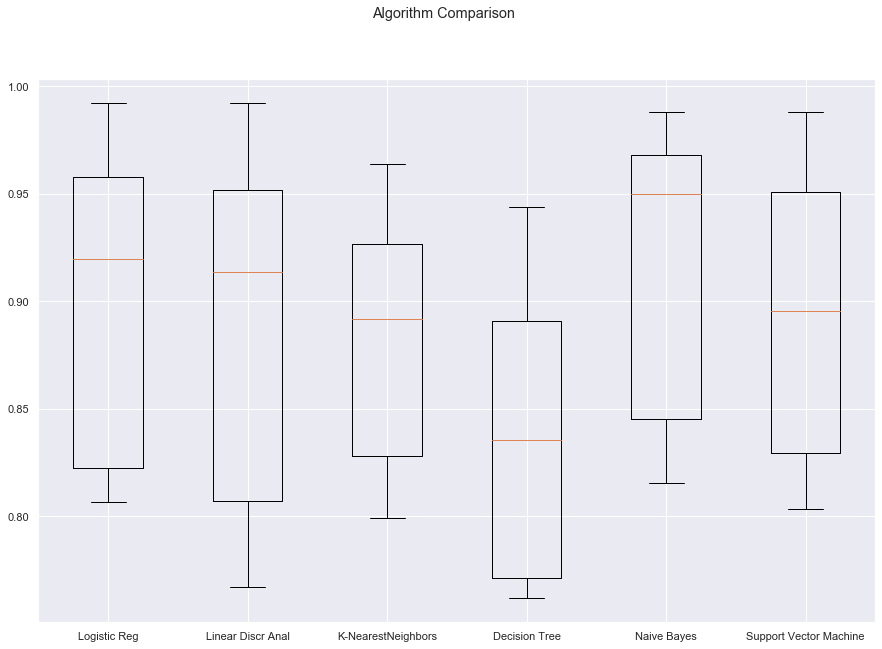

In [81]:
fig = plt.figure(figsize = (15, 10))
sns.set(font_scale = 1) 
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(AccResults)
ax.set_xticklabels(algos)
plt.show()

## 3.2 Support Vector Machine Classifier

### World Class prediction

#### The goal of this model is to predict the World Class of a given country for a specific year based on 5 features: Mortality, HIV, Income, Schooling and Sanitation. Life expectancy will not be included in the model, because the grouping was made based on every country's lifespan.

#### Running the baseline model

In [82]:
X1 = winsorizedImputedSelectedFeats.iloc[:, 7:-2]
Y1 = winsorizedImputedSelectedFeats.iloc[:,-2]

In [83]:
scaler.fit(X1)
X1 = scaler.transform(X1)

In [84]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)

In [85]:
svc=SVC()
svc.fit(X1_train,Y1_train)
y1Pred=svc.predict(X1_test)
print('Accuracy score of baseline model:')
print(metrics.accuracy_score(Y1_test,y1Pred))

Accuracy score of baseline model:
0.9158878504672897


#### Running the model with hyperparameter tuning

In [86]:
gridParams1 = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']}
CrossValSVC1 = GridSearchCV(estimator=svc, param_grid=gridParams1, cv= 10)
CrossValSVC1.fit(X1_train, Y1_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
CrossValSVC1.best_params_

{'C': 1000, 'kernel': 'rbf'}

In [88]:
CrossValSVCBest1 = SVC(C = 1000, kernel = 'rbf' )
CrossValSVCBest1.fit(X1_train, Y1_train)
predBest1 = CrossValSVCBest1.predict(X1_test)
print('Accuracy score of baseline model:')
print(metrics.accuracy_score(Y1_test,y1Pred))
print('The accuracy score for the best hyperparameters:')
print(metrics.accuracy_score(Y1_test,predBest1))
worldClassAcc = metrics.accuracy_score(Y1_test,predBest1)

Accuracy score of baseline model:
0.9158878504672897
The accuracy score for the best hyperparameters:
0.9385847797062751


##### The accuracy of our model increased 2.3% after the hyperparameter tuning.

#### Plot the confusion matrix as a heatmap

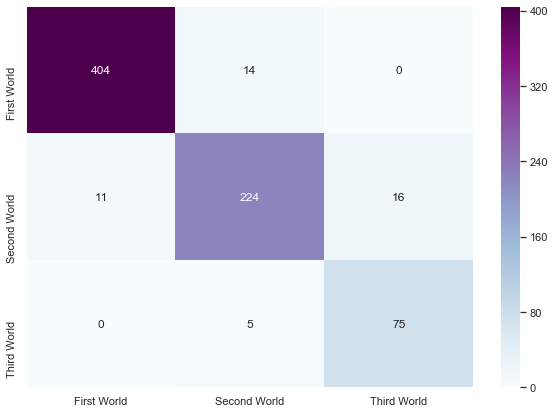

In [89]:
confMA1 = confusion_matrix(Y1_test, predBest1)
classes1 = ['First World', 'Second World', 'Third World']
DFconfMA1 = pd.DataFrame(confMA1, index = [i for i in classes1], columns = [i for i in classes1])
plt.figure(figsize = (10,7))
sns.heatmap(DFconfMA1, annot=True, cmap='BuPu', fmt='g')

### Status prediction

#### The goal of this model is to predict the Status of a given country for a specific year based on 5 features: Mortality, HIV, Income, Schooling and Sanitation.

#### Running the baseline model

In [90]:
X2 = winsorizedImputedSelectedFeats.iloc[:, 7:-2]
Y2 = winsorizedImputedSelectedFeats.iloc[:,1]
Y2 = Y2.map({'Developing': 0, 'Developed': 1})

In [91]:
scaler.fit(X2)
X2 = scaler.transform(X2)

In [92]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.3, random_state=42)

In [93]:
svc=SVC()
svc.fit(X2_train,Y2_train)
y2Pred=svc.predict(X2_test)
print('Accuracy score of baseline model:')
print(metrics.accuracy_score(Y2_test, y2Pred))

Accuracy score of baseline model:
0.87716955941255


#### Running the model with hyperparameter tuning

In [94]:
gridParams2 = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']}
CrossValSVC2 = GridSearchCV(estimator=svc, param_grid=gridParams2, cv= 10)
CrossValSVC2.fit(X2_train, Y2_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [95]:
CrossValSVC2.best_params_

{'C': 100, 'kernel': 'rbf'}

In [96]:
CrossValSVCBest2 = SVC(C = 100, kernel = 'rbf' )
CrossValSVCBest2.fit(X2_train, Y2_train)
predBest2 = CrossValSVCBest2.predict(X2_test)
print('Accuracy score of baseline model:')
print(metrics.accuracy_score(Y2_test,y2Pred))
print('The accuracy score for the best hyperparameters:')
print(metrics.accuracy_score(Y2_test,predBest2))
statusAcc = metrics.accuracy_score(Y2_test,predBest2)

Accuracy score of baseline model:
0.87716955941255
The accuracy score for the best hyperparameters:
0.8851802403204272


##### The accuracy of our model increased 2.4% after the hyperparameter tuning.

#### Plot the confusion matrix as a heatmap

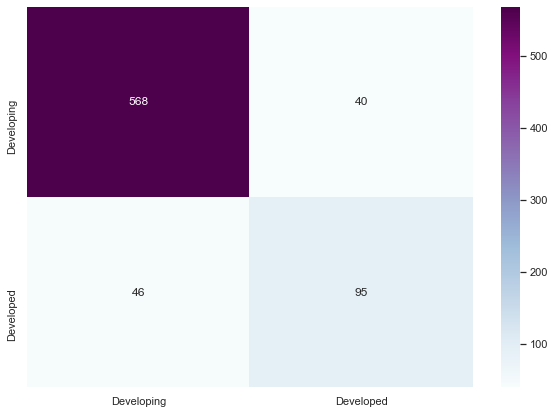

In [97]:
confMA2 = confusion_matrix(Y2_test, predBest2)
classes2 = ['Developing', 'Developed']
DFconfMA2 = pd.DataFrame(confMA2, index = [i for i in classes2], columns = [i for i in classes2])
plt.figure(figsize = (10,7))
sns.heatmap(DFconfMA2, annot=True, cmap='BuPu', fmt='g')

### Cluster prediction

#### The goal of this model is to predict the cluster of a given country for a specific year based on 5 features: Mortality, HIV, Income, Schooling and Sanitation.

#### Running the baseline model

In [98]:
X3 = winsorizedImputedSelectedFeats.iloc[:, 7:-2]
X3.drop(X3.tail(7).index,inplace=True)
Y3 = winsorizedImputedSelectedFeats.iloc[:,-1]
Y3.drop(Y3.tail(7).index,inplace=True)

In [99]:
scaler.fit(X3)
X3 = scaler.transform(X3)

In [100]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.3, random_state=42)

In [101]:
svc=SVC()
svc.fit(X3_train,Y3_train)
y3Pred=svc.predict(X3_test)
print('Accuracy score of baseline model:')
print(metrics.accuracy_score(Y3_test, y3Pred))

Accuracy score of baseline model:
0.9049531459170014


#### Running the model with hyperparameter tuning

In [102]:
gridParams3 = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']}
CrossValSVC3 = GridSearchCV(estimator=svc, param_grid = gridParams3, cv= 10)
CrossValSVC3.fit(X3_train, Y3_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [103]:
CrossValSVC3.best_params_

{'C': 100, 'kernel': 'rbf'}

In [104]:
CrossValSVCBest3 = SVC(C = 100, kernel = 'rbf' )
CrossValSVCBest3.fit(X3_train, Y3_train)
predBest3 = CrossValSVCBest3.predict(X3_test)
print('Accuracy score of baseline model:')
print(metrics.accuracy_score(Y3_test,y3Pred))
print('The accuracy score for the best hyperparameters:')
print(metrics.accuracy_score(Y3_test,predBest3))
clusterAcc = metrics.accuracy_score(Y3_test,predBest3)

Accuracy score of baseline model:
0.9049531459170014
The accuracy score for the best hyperparameters:
0.9143239625167336


##### The accuracy of our model increased 1.74% after the hyperparameter tuning.

#### Plot the confusion matrix as a heatmap

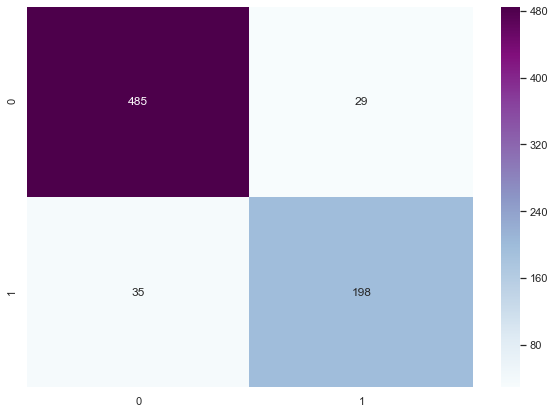

In [105]:
confMA3 = confusion_matrix(Y3_test, predBest3)
classes3 = ['0', '1']
DFconfMA3 = pd.DataFrame(confMA3, index = [i for i in classes3], columns = [i for i in classes3])
plt.figure(figsize = (10,7))
sns.heatmap(DFconfMA3, annot=True, cmap='BuPu', fmt='g')

In [106]:
print('The highest accuracy was achieved for the world class prediction with an accuracy of ', worldClassAcc*100, '%')
print('The second highest accuracy was achieved for the cluster prediction with an accuracy of ', clusterAcc*100, '%')
print('The third highest accuracy was achieved for the status prediction with an accuracy of ', statusAcc*100, '%')

The highest accuracy was achieved for the world class prediction with an accuracy of  93.8584779706275 %
The second highest accuracy was achieved for the cluster prediction with an accuracy of  91.43239625167337 %
The third highest accuracy was achieved for the status prediction with an accuracy of  88.51802403204272 %
